## `Demand Forecasting for E-Commerce`

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.interpolate import make_interp_spline
from statsmodels.tsa.seasonal import STL
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

### Functions

#### Outlier Function

In [ ]:
def removeOutlierFunction(row, percentile_5, percentile_95, replace_percentile_5, replace_percentile_95 ):
    if row < percentile_5:
        return replace_percentile_5
    elif row > percentile_95:
        return replace_percentile_95
    else:
        return row

#### Skew Function

In [ ]:
def skewValue(Dataframe):
    skewness = Dataframe.skew()
    if skewness > 0:
        print(f"- {Dataframe.name}: Value of skewness : {skewness} => The data is positively skewed i.e right skewed. ")
    elif skewness < 0:
        print(f"- {Dataframe.name}: Value of skewness : {skewness} => The data is negatively skewed i.e left skewed.")
    else:
        print(f"- {Dataframe.name}: Value of skewness : {skewness} => The data is symmetrical.")

#### Converting function

In [ ]:
def convertDataIntoWeekDays_Week_Month(Dataframe, DayIndex, WD_W_M, column):
    df_copy = Dataframe.copy(True)
    df_copy[DayIndex] = pd.to_datetime(df_copy[DayIndex])
    if WD_W_M == 0:
        type = 'Weekday'
        typeNum = 'Weekday_Num'
        df_copy[type] = df_copy[DayIndex].dt.day_name()
        df_copy[typeNum] = df_copy[DayIndex].dt.dayofweek
        weekday_sum = df_copy.groupby([type, typeNum])[column].sum().reset_index()
        weekday_sum_sorted = weekday_sum.sort_values(typeNum).reset_index(drop=True)
        return weekday_sum_sorted
    if WD_W_M == 1:
        typeNum = 'Week_Num'
        df_copy[typeNum] = df_copy[DayIndex].dt.isocalendar().week
        week_sum = df_copy.groupby(typeNum)[column].sum().reset_index()
        week_sum_sorted = week_sum.sort_values(typeNum).reset_index(drop=True)
        # Shuffling
        last_5_rows = week_sum_sorted.iloc[-5:]
        shuffled_last_5 = last_5_rows.sample(frac=1).reset_index(drop=True)
        rest_of_df = week_sum_sorted.iloc[:-5]
        week_sum_new = pd.concat([shuffled_last_5, rest_of_df], ignore_index=True)
        return week_sum_new
    if WD_W_M == 2:
        type = 'Month'
        typeNum = 'Month_Num'
        df_copy[type] = df_copy[DayIndex].dt.month_name()
        df_copy[typeNum] = df_copy[DayIndex].dt.month
        month_sum = df_copy.groupby([type, typeNum])[column].sum().reset_index()
        month_sum_sorted = month_sum.sort_values(typeNum).reset_index(drop=True)
        # Shuffling
        last_row = month_sum_sorted.iloc[-1:]
        shuffled_last = last_row.sample(frac=1).reset_index(drop=True)
        rest_of_df = month_sum_sorted.iloc[:-1]
        month_sum_new = pd.concat([shuffled_last, rest_of_df], ignore_index=True)
        return month_sum_new

#### ADF Test

In [ ]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#### KPSS Test

In [ ]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

#### LR Model Function

In [ ]:
def LRModelResult(X, y):
    X_train, X_test, y_train, y_test = train_test_split( X, y, train_size = 0.7, test_size = 0.3)
    lr = LinearRegression()
    lr.fit(X_train.values.reshape(-1,1), y_train.values)
    prediction = lr.predict(X_test.values.reshape(-1,1))
    plt.plot(X_test, prediction, label='Linear Regression', color='b')
    plt.scatter(X_train, y_train, label = "Training Data", color = 'red', alpha=.7)
    plt.scatter(X_test, y_test, label= "Testing Data", color='green', alpha=.7)
    plt.title('Data Spliting and Linear Model')
    plt.legend()
    plt.show()
    print(f'R-square or Score: {lr.score(X_test.values.reshape(-1,1), y_test.values)}')
    print(f'Slope            : {lr.coef_}')

#### AR, MA, ARIMA Model

In [ ]:
def AR_MA_ARIMA_Model_TestingAndValidation(p,d,q,Dataframe, col, trainDataSize, testDataSize):
    product_clicks_impression_temp = Dataframe.copy()
    product_clicks_impression_temp = Dataframe.set_index('Day Index')
    train_size = int(trainDataSize * len(product_clicks_impression_temp))
    validation_size = int(testDataSize * len(product_clicks_impression_temp))

    train_data = product_clicks_impression_temp.iloc[:train_size][col]
    validation_data = product_clicks_impression_temp.iloc[train_size:train_size+validation_size][col]
    test_data = product_clicks_impression_temp.iloc[train_size+validation_size:][col]

    # ARIMA Model
    order = (p, d, q)
    arima_model = ARIMA(train_data, order=order)
    arima_result = arima_model.fit()

    # Step 6: Forecast using the model
    test_forecast = arima_result.forecast(len(test_data))
    validation_forecast = arima_result.forecast(len(validation_data))

    plt.figure(figsize=(20, 5))
    date1 = product_clicks_impression_temp.iloc[:train_size].index
    date2 = product_clicks_impression_temp.iloc[train_size:train_size+validation_size].index
    date3 = product_clicks_impression_temp.iloc[train_size+validation_size:].index
    # Actual values plotting
    plt.plot(date1, train_data.values, label='Actual- Train')
    plt.plot(date2, validation_data.values, label='Actual- Validation', color='green')
    plt.plot(date3, test_data.values, label='Actual- Test', color='blue')

    # Forecaste Plot
    plt.plot(validation_data.index, validation_forecast, label='Forecast- Validation', color='m', linestyle='--')
    plt.plot(test_data.index, test_forecast, label='Forecast- Test', color='red', linestyle='--')

    if p == 0:
        plt.title('MA Train Vs Validation Vs Test Data')
    if q == 0:
        plt.title('AR Train Vs Validation Vs Test Data')
    else:
        plt.title('ARIMA Train Vs Validation Vs Test Data')
    plt.xlabel('Time')
    plt.ylabel('Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()

    validation_mae = mean_absolute_error(validation_data, validation_forecast)
    validation_mape = mean_absolute_percentage_error(validation_data, validation_forecast)
    validation_rmse = np.sqrt(mean_squared_error(validation_data, validation_forecast))
    valid_r_2 = r2_score(validation_data, validation_forecast)
    n_valid = len(validation_data)
    par = 1
    valid_adjusted_r_2 = 1 - (1 - valid_r_2) * (n_valid - 1) / (n_valid - par - 1)

    test_mae = mean_absolute_error(test_data, test_forecast)
    test_mape = mean_absolute_percentage_error(test_data, test_forecast)
    test_rmse = np.sqrt(mean_squared_error(test_data, test_forecast))
    test_r_2 = r2_score(test_data, test_forecast)
    n_test = len(test_data)
    test_adjusted_r_2 = 1 - (1 - test_r_2) * (n_test - 1) / (n_test - par - 1)

    print('Validation Data: ')
    print(f'MAE  : {validation_mae.round(4)}, RMSE  : {validation_rmse.round(4)}, MAPE  : {(validation_mape*100).round(4)}%, R-Square:  {valid_r_2.round(4)},  Adjusted R-Square  : {valid_adjusted_r_2.round(4)}')
    print('Test Data: ')
    print(f'MAE  : {test_mae.round(4)}, RMSE  : {test_rmse.round(4)}, MAPE  : {(test_mape*100).round(4)}, R-Square : {test_r_2.round(4)}, Adjusted R-Square : {test_adjusted_r_2.round(4)}')
    return arima_result

#### ARIMAX

In [ ]:
def ARIMAX_Model(p,d,q,Dataframe, col,exog_cols, trainDataSize, testDataSize):
    product_clicks_impression_temp = Dataframe.copy()
    product_clicks_impression_temp = Dataframe.set_index('Day Index')
    train_size = int(trainDataSize * len(product_clicks_impression_temp))
    validation_size = int(testDataSize * len(product_clicks_impression_temp))

    train_data = product_clicks_impression_temp.iloc[:train_size][col]
    validation_data = product_clicks_impression_temp.iloc[train_size:train_size+validation_size][col]
    test_data = product_clicks_impression_temp.iloc[train_size+validation_size:][col]

    # ARIMAX Model
    order = (p, d, q)
    exog_data = product_clicks_impression_temp.iloc[:train_size][exog_cols]
    exog_data_valid = product_clicks_impression_temp.iloc[train_size:train_size+validation_size][exog_cols]
    exog_data_test = product_clicks_impression_temp.iloc[train_size+validation_size:][exog_cols]
    arima_model = ARIMA(train_data, order=order,exog=exog_data)
    arima_result = arima_model.fit()

    # Step 6: Forecast using the model
    forecast_test = arima_result.get_forecast(steps=len(test_data), exog=exog_data_test)
    forecast_values_test = forecast_test.predicted_mean
    fitted_values = arima_result.fittedvalues
    forecast_test = arima_result.get_forecast(steps=len(validation_data), exog=exog_data_valid)
    forecast_values_valid = forecast_test.predicted_mean

    plt.figure(figsize=(20, 5))
    date1 = product_clicks_impression_temp.iloc[:train_size].index
    date2 = product_clicks_impression_temp.iloc[train_size:train_size+validation_size].index
    date3 = product_clicks_impression_temp.iloc[train_size+validation_size:].index
    # Actual values plotting
    plt.plot(date1, train_data.values, label='Actual- Train')
    plt.plot(date2, validation_data.values, label='Actual- Validation', color='green')
    plt.plot(date3, test_data.values, label='Actual- Test', color='blue')

    # Forecaste Plot
    plt.plot(test_data.index, forecast_values_test, label='Forecast- Test', color='red', linestyle='--')
    plt.plot(validation_data.index, forecast_values_valid, label='Forecast- Validation', color='m', linestyle='--')

    if p == 0:
        plt.title('MAX Train Vs Validation Vs Test Data')
    if q == 0:
        plt.title('ARX Train Vs Validation Vs Test Data')
    else:
        plt.title('ARIMAX Train Vs Validation Vs Test Data')
    plt.xlabel('Time')
    plt.ylabel('Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()

    valid_mae = mean_absolute_error(validation_data, forecast_values_valid)
    valid_rmse = np.sqrt(mean_squared_error(validation_data, forecast_values_valid))
    valid_mape = mean_absolute_percentage_error(validation_data, forecast_values_valid)
    valid_r_2 = r2_score(validation_data, forecast_values_valid)
    n_valid = len(validation_data)
    par = len(exog_cols)
    valid_adjusted_r_2 = 1 - (1 - valid_r_2) * (n_valid - 1) / (n_valid - par - 1)

    test_mae = mean_absolute_error(test_data, forecast_values_test)
    test_rmse = np.sqrt(mean_squared_error(test_data, forecast_values_test))
    test_mape = mean_absolute_percentage_error(test_data, forecast_values_test)
    test_r_2 = r2_score(test_data, forecast_values_test)
    n_test = len(test_data)
    test_adjusted_r_2 = 1 - (1 - test_r_2) * (n_test - 1) / (n_test - par - 1)
    print('Validation Data: ')
    print(f'MAE  : {valid_mae.round(4)}, RMSE  : {valid_rmse.round(4)}, MAPE  : {(valid_mape*100).round(4)}%, R-square  : {valid_r_2.round(4)}, Adjusted R-square  : {valid_adjusted_r_2.round(4)}')
    print('Test Data: ')
    print(f'MAE  : {test_mae.round(4)}, RMSE  : {test_rmse.round(4)}, MAPE  : {(test_mape*100).round(4)}%, R-square  : {test_r_2.round(4)}, Adjusted R-square  : {test_adjusted_r_2.round(4)}')
    return arima_result

#### SARIMA

In [ ]:
def SARIMA_Model(Dataframe, p, d, q, ratioTest,ratioValidate, attributeQ,SOp,SOd,SOq,SOseason):
    product_clicks_impression_temp = Dataframe.copy()
    product_clicks_impression_temp = Dataframe.set_index('Day Index')
    train_size = int(ratioTest * len(product_clicks_impression_temp))
    validation_size = int(ratioValidate * len(product_clicks_impression_temp))

    df_train = product_clicks_impression_temp.iloc[:train_size][attributeQ]
    df_valid = product_clicks_impression_temp.iloc[train_size:train_size+validation_size][attributeQ]
    df_test = product_clicks_impression_temp.iloc[train_size + validation_size:][attributeQ]


    order = (p, d, q)
    seasonal_order=(SOp,SOd,SOq,SOseason)

    model = SARIMAX(df_train, order=order,seasonal_order=seasonal_order)
    model_fit = model.fit()

    forecast_test = model_fit.get_forecast(steps=len(df_test))
    forecast_values_test = forecast_test.predicted_mean
    forecast_test = model_fit.get_forecast(steps=len(df_valid))
    forecast_values_valid = forecast_test.predicted_mean

    plt.figure(figsize=(20, 5))
    date1 = product_clicks_impression_temp.iloc[:train_size].index
    date2 = product_clicks_impression_temp.iloc[train_size:train_size+validation_size].index
    date3 = product_clicks_impression_temp.iloc[train_size+validation_size:].index
    # Actual values plotting
    plt.plot(date1, df_train.values, label='Actual- Train')
    plt.plot(date2, df_valid.values, label='Actual- Validation', color='green')
    plt.plot(date3, df_test.values, label='Actual- Test', color='blue')

    # Forecaste Plot
    plt.plot(df_test.index, forecast_values_test, label='Forecast- Test', color='m', linestyle='--')
    plt.plot(df_valid.index, forecast_values_valid, label='Forecast- Validation', color='red', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()
    valid_mae = mean_absolute_error(df_valid, forecast_values_valid)
    valid_rmse = np.sqrt(mean_squared_error(df_valid, forecast_values_valid))
    valid_mape = mean_absolute_percentage_error(df_valid, forecast_values_valid)
    valid_r_2 = r2_score(df_valid, forecast_values_valid)
    n_valid = len(df_valid)
    par = 1
    valid_adjusted_r_2 = 1 - (1 - valid_r_2) * (n_valid - 1) / (n_valid - par - 1)

    test_mae = mean_absolute_error(df_test, forecast_values_test)
    test_rmse = np.sqrt(mean_squared_error(df_test, forecast_values_test))
    test_mape = mean_absolute_percentage_error(df_test, forecast_values_test)
    test_r_2 = r2_score(df_test, forecast_values_test)
    n_test = len(df_test)
    test_adjusted_r_2 = 1 - (1 - test_r_2) * (n_test - 1) / (n_test - par - 1)
    print('Validation Data: ')
    print(f'MAE  : {valid_mae.round(4)}, RMSE  : {valid_rmse.round(4)}, MAPE  : {(valid_mape*100).round(4)}%, R-square  : {valid_r_2.round(4)}, Adjusted R-square  : {valid_adjusted_r_2.round(4)}')
    print('Test Data: ')
    print(f'MAE  : {test_mae.round(4)}, RMSE  : {test_rmse.round(4)}, MAPE  : {(test_mape*100).round(4)}%, R-square  : {test_r_2.round(4)}, Adjusted R-square  : {test_adjusted_r_2.round(4)}')
    return model_fit

#### SARIMAX Model

##### SARIMAX

In [ ]:
def SARIMAX_Model(Dataframe, p, d, q, ratioTest,ratioValidate, attributeQ, exog_cols,SOp,SOd,SOq,SOseason):
    product_clicks_impression_temp = Dataframe.copy()
    product_clicks_impression_temp = Dataframe.set_index('Day Index')
    train_size = int(ratioTest * len(product_clicks_impression_temp))
    validation_size = int(ratioValidate * len(product_clicks_impression_temp))

    df_train = product_clicks_impression_temp.iloc[:train_size][attributeQ]
    df_valid = product_clicks_impression_temp.iloc[train_size:train_size+validation_size][attributeQ]
    df_test = product_clicks_impression_temp.iloc[train_size + validation_size:][attributeQ]


    order = (p, d, q)
    seasonal_order=(SOp,SOd,SOq,SOseason)
    exog_data = product_clicks_impression_temp.iloc[:train_size][exog_cols]
    exog_data_valid = product_clicks_impression_temp.iloc[train_size:train_size+validation_size][exog_cols]
    exog_data_test = product_clicks_impression_temp.iloc[train_size+validation_size:][exog_cols]

    model = SARIMAX(df_train, order=order, exog=exog_data,seasonal_order=seasonal_order)
    model_fit = model.fit()

    forecast_test = model_fit.get_forecast(steps=len(df_test), exog=exog_data_test)
    forecast_values_test = forecast_test.predicted_mean
    forecast_test = model_fit.get_forecast(steps=len(df_valid), exog=exog_data_valid)
    forecast_values_valid = forecast_test.predicted_mean

    plt.figure(figsize=(20, 5))
    date1 = product_clicks_impression_temp.iloc[:train_size].index
    date2 = product_clicks_impression_temp.iloc[train_size:train_size+validation_size].index
    date3 = product_clicks_impression_temp.iloc[train_size+validation_size:].index
    # Actual values plotting
    plt.plot(date1, df_train.values, label='Actual- Train')
    plt.plot(date2, df_valid.values, label='Actual- Validation', color='green')
    plt.plot(date3, df_test.values, label='Actual- Test', color='blue')

    # Forecaste Plot
    plt.plot(df_test.index, forecast_values_test, label='Forecast- Test', color='m', linestyle='--')
    plt.plot(df_valid.index, forecast_values_valid, label='Forecast- Validation', color='red', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()
    valid_mae = mean_absolute_error(df_valid, forecast_values_valid)
    valid_rmse = np.sqrt(mean_squared_error(df_valid, forecast_values_valid))
    valid_mape = mean_absolute_percentage_error(df_valid, forecast_values_valid)
    valid_r_2 = r2_score(df_valid, forecast_values_valid)
    n_valid = len(df_valid)
    par = len(exog_cols)
    valid_adjusted_r_2 = 1 - (1 - valid_r_2) * (n_valid - 1) / (n_valid - par - 1)

    test_mae = mean_absolute_error(df_test, forecast_values_test)
    test_rmse = np.sqrt(mean_squared_error(df_test, forecast_values_test))
    test_mape = mean_absolute_percentage_error(df_test, forecast_values_test)
    test_r_2 = r2_score(df_test, forecast_values_test)
    n_test = len(df_test)
    test_adjusted_r_2 = 1 - (1 - test_r_2) * (n_test - 1) / (n_test - par - 1)
    print('Validation Data: ')
    print(f'MAE  : {valid_mae.round(4)}, RMSE  : {valid_rmse.round(4)}, MAPE  : {(valid_mape*100).round(4)}%, R-square  : {valid_r_2.round(4)}, Adjusted R-square  : {valid_adjusted_r_2.round(4)}')
    print('Test Data: ')
    print(f'MAE  : {test_mae.round(4)}, RMSE  : {test_rmse.round(4)}, MAPE  : {(test_mape*100).round(4)}%, R-square  : {test_r_2.round(4)}, Adjusted R-square  : {test_adjusted_r_2.round(4)}')
    return model_fit

##### Iterative SARIMAX

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, r2_score

def SARIMAX_IterativeModel(Dataframe, p, d, q, SOp, SOd, SOq, SOseason, ratioTest, validationRatio, attributeQ, startModelNo, EndModelNo, subsets):
    product_clicks_impression_temp = Dataframe.copy()
    product_clicks_impression_temp = product_clicks_impression_temp.set_index('Day Index')  # Corrected

    train_size = int(ratioTest * len(product_clicks_impression_temp))
    validation_size = int(validationRatio * len(product_clicks_impression_temp))

    df_train = product_clicks_impression_temp.iloc[:train_size][attributeQ]
    df_valid = product_clicks_impression_temp.iloc[train_size:train_size+validation_size][attributeQ]  # Corrected
    df_test = product_clicks_impression_temp.iloc[train_size+validation_size:][attributeQ]  # Corrected

    exog_cols = subsets[startModelNo:EndModelNo]

    list_mape = []
    order = (p, d, q)
    seasonal_order = (SOp, SOd, SOq, SOseason)

    for col in exog_cols:
        exog_data = product_clicks_impression_temp.iloc[:train_size][col]
        exog_data_valid = product_clicks_impression_temp.iloc[train_size:train_size+validation_size][col]
        exog_data_test = product_clicks_impression_temp.iloc[train_size+validation_size:][col]

        model = SARIMAX(df_train, order=order, exog=exog_data, seasonal_order=seasonal_order)
        model_fit = model.fit()

        forecast_valid = model_fit.get_forecast(steps=len(df_valid), exog=exog_data_valid)
        forecast_values_valid = forecast_valid.predicted_mean

        forecast_test = model_fit.get_forecast(steps=len(df_test), exog=exog_data_test)
        forecast_values_test = forecast_test.predicted_mean

        valid_mape = mean_absolute_percentage_error(df_valid, forecast_values_valid)
        valid_r_2 = r2_score(df_valid, forecast_values_valid)
        n_valid = len(df_valid)
        par = len(col)
        valid_adjusted_r_2 = 1 - (1 - valid_r_2) * (n_valid - 1) / (n_valid - par - 1)

        test_mape = mean_absolute_percentage_error(df_test, forecast_values_test)
        test_r_2 = r2_score(df_test, forecast_values_test)
        n_test = len(df_test)
        test_adjusted_r_2 = 1 - (1 - test_r_2) * (n_test - 1) / (n_test - par - 1)

        list_mape.append((col, test_mape, test_r_2, test_adjusted_r_2, valid_mape, valid_r_2, valid_adjusted_r_2))

    return list_mape


#### MLR : Multi Linear Regression

In [ ]:
def MLR_Model(Dataframe, target, trainRatio, validationRatio, colList):
    product_clicks_impression_temp = Dataframe.copy()
    product_clicks_impression_temp = Dataframe.set_index('Day Index')
    train_size = int(trainRatio * len(product_clicks_impression_temp))
    validation_size = int(validationRatio * len(product_clicks_impression_temp))

    X_train_data = product_clicks_impression_temp.iloc[:train_size][colList]
    Y_train_data = product_clicks_impression_temp.iloc[:train_size][target]
    X_validation_data = product_clicks_impression_temp.iloc[train_size:train_size+validation_size][colList]
    Y_validation_data = product_clicks_impression_temp.iloc[train_size:train_size+validation_size][target]
    X_test_data = product_clicks_impression_temp.iloc[train_size+validation_size:][colList]
    Y_test_data = product_clicks_impression_temp.iloc[train_size+validation_size:][target]

    # Train the model
    model = LinearRegression()
    model.fit(X_train_data, Y_train_data)

    valid_predict = model.predict(X_validation_data)
    test_predict = model.predict(X_test_data)

    plt.figure(figsize=(20, 5))
    date1 = product_clicks_impression_temp.iloc[:train_size].index
    date2 = product_clicks_impression_temp.iloc[train_size:train_size+validation_size].index
    date3 = product_clicks_impression_temp.iloc[train_size+validation_size:].index

    # Actual values plotting
    plt.plot(date1, Y_train_data.values, label='Actual- Train')
    plt.plot(date2, Y_validation_data.values, label='Actual- Validation', color='green')
    plt.plot(date3, Y_test_data.values, label='Actual- Test', color='blue')

    # Forecaste Plot
    plt.plot(Y_test_data.index, test_predict, label='Forecast- Test', color='m', linestyle='--')
    plt.plot(Y_validation_data.index, valid_predict, label='Forecast- Validation', color='red', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()
    valid_mae = mean_absolute_error(Y_validation_data, valid_predict)
    valid_rmse = np.sqrt(mean_squared_error(Y_validation_data, valid_predict))
    valid_mape = mean_absolute_percentage_error(Y_validation_data, valid_predict)
    valid_r_2 = r2_score(Y_validation_data, valid_predict)
    n_valid = len(Y_validation_data)
    p = len(colList)
    valid_adjusted_r_2 = 1 - (1 - valid_r_2) * (n_valid - 1) / (n_valid - p - 1)

    test_mae = mean_absolute_error(Y_test_data, test_predict)
    test_rmse = np.sqrt(mean_squared_error(Y_test_data, test_predict))
    test_mape = mean_absolute_percentage_error(Y_test_data, test_predict)
    test_r_2 = r2_score(Y_test_data, test_predict)
    n_test = len(Y_test_data)

    test_adjusted_r_2 = 1 - (1 - test_r_2) * (n_test - 1) / (n_test - p - 1)
    print('Validation Data: ')
    print(f'MAE  : {valid_mae.round(4)}, RMSE  : {valid_rmse.round(4)}, MAPE  : {(valid_mape*100).round(4)}%, R-square  : {valid_r_2.round(4)}, Adjusted R-square  : {valid_adjusted_r_2.round(4)}')
    print('Test Data: ')
    print(f'MAE  : {test_mae.round(4)}, RMSE  : {test_rmse.round(4)}, MAPE  : {(test_mape*100).round(4)}%, R-square  : {test_r_2.round(4)}, Adjusted R-square  : {test_adjusted_r_2.round(4)}')
    return model

### Importing and merging Data

In [ ]:
data_product_A = pd.read_excel('ProductA.xlsx')
data_google_clicks = pd.read_excel('ProductA_google_clicks.xlsx')
data_facebook_impressions = pd.read_excel('ProductA_fb_impressions.xlsx')

In [ ]:
merged_df = pd.merge(data_product_A, data_google_clicks, on='Day Index', how='left')
product_clicks_impression = pd.merge(merged_df, data_facebook_impressions, on='Day Index', how='left')
product_clicks_impression

,Day Index,Quantity,Clicks,Impressions
0,2021-12-01,14,445,620
1,2021-12-02,10,433,890
2,2021-12-03,13,424,851
3,2021-12-04,22,427,881
4,2021-12-05,33,451,678
...,...,...,...,...
207,2022-06-26,13,114,1218
208,2022-06-27,16,106,1311
209,2022-06-28,13,109,885
210,2022-06-29,16,60,1000


Skipping histogram for column 'Day Index' (not numeric).


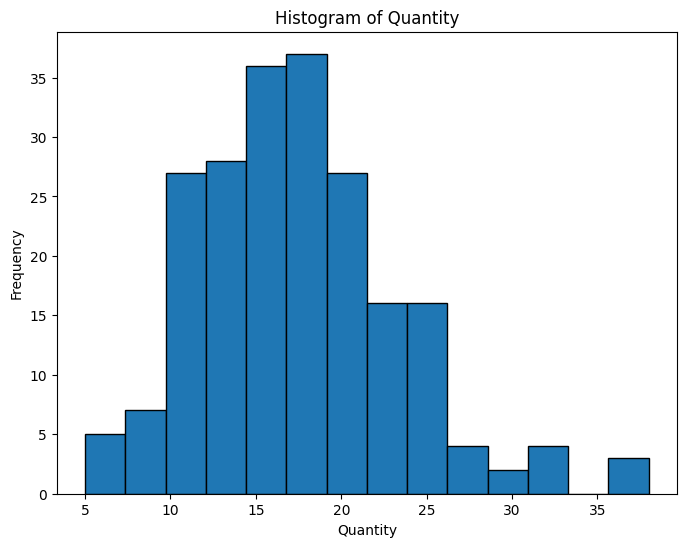

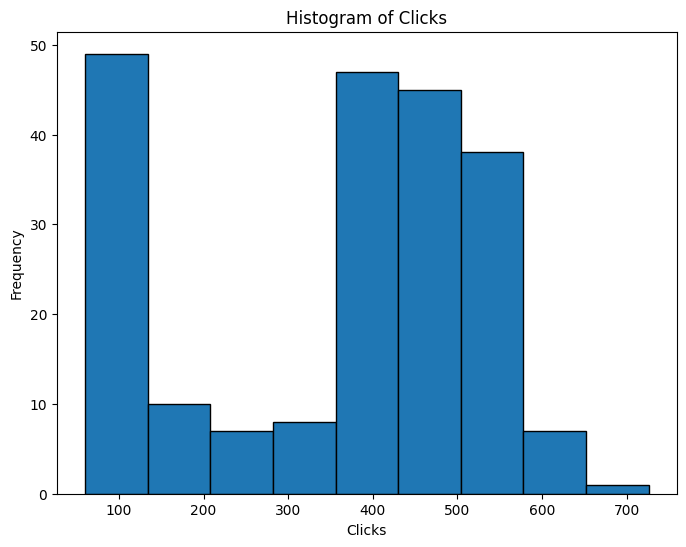

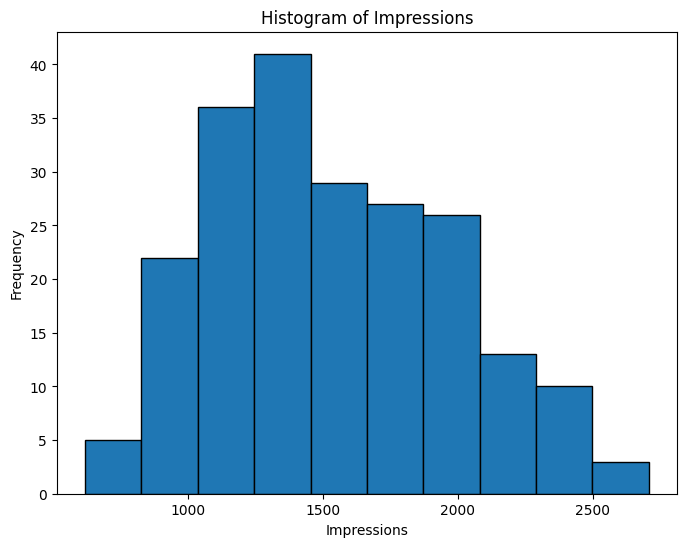

In [ ]:
# prompt: Using dataframe product_clicks_impression: generate histogram of all columns with code

import matplotlib.pyplot as plt

# Iterate through each column in the DataFrame
for column in product_clicks_impression.columns:
    # Check if the column's data type is numeric
    if pd.api.types.is_numeric_dtype(product_clicks_impression[column]):
        # Create a histogram for the numeric column
        plt.figure(figsize=(8, 6))  # Adjust figure size as needed
        plt.hist(product_clicks_impression[column], bins='auto', edgecolor='black') # bins='auto' automatically determines the number of bins
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()
    else:
        # Handle non-numeric columns (e.g., print a message)
        print(f"Skipping histogram for column '{column}' (not numeric).")


In [ ]:
# prompt: Using dataframe product_clicks_impression: scatter plot between  impressions and clicks with linear line

import altair as alt

# Create the scatter plot
chart = alt.Chart(product_clicks_impression).mark_point().encode(
    x='Impressions',
    y='Clicks'
)

# Calculate the linear regression trendline
trendline = chart.transform_regression('Impressions', 'Clicks').mark_line()

# Combine the scatter plot and the trendline
chart + trendline


alt.LayerChart(...)

In [ ]:
print("Shpae of dataframe: ",product_clicks_impression.shape, "\n")

Shpae of dataframe:  (212, 4) 



In [ ]:
print("Data Info :")
product_clicks_impression.info()

Data Info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Day Index    212 non-null    datetime64[ns]
 1   Quantity     212 non-null    int64         
 2   Clicks       212 non-null    int64         
 3   Impressions  212 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 6.8 KB


In [ ]:
print("Null Values check:")
print(product_clicks_impression.isnull().sum(), "\n")

Null Values check:
Day Index      0
Quantity       0
Clicks         0
Impressions    0
dtype: int64 



In [ ]:
print("Data Details:")
print(product_clicks_impression.describe(), "\n")

Data Details:
                 Day Index    Quantity     Clicks  Impressions
count                  212  212.000000  212.00000   212.000000
mean   2022-03-16 12:00:00   17.542453  358.20283  1531.702830
min    2021-12-01 00:00:00    5.000000   60.00000   620.000000
25%    2022-01-22 18:00:00   13.750000  154.00000  1209.750000
50%    2022-03-16 12:00:00   17.000000  402.50000  1460.000000
75%    2022-05-08 06:00:00   21.000000  492.75000  1862.000000
max    2022-06-30 00:00:00   38.000000  726.00000  2707.000000
std                    NaN    5.790423  164.52160   440.660783 



- Data consist of 212 rows and 4 columns
- No null values

#### Functions

In [ ]:
# Daily
def daily():
    plt.figure(figsize=(24,6))
    plt.plot(product_clicks_impression['Day Index'], product_clicks_impression['Quantity'].div(1000), color = 'orange', marker = 'o', label= 'Quantity',markerfacecolor = '#42adf5')
    plt.plot(product_clicks_impression['Day Index'], product_clicks_impression['Impressions'].div(100000), color = 'r', marker = 'o', label='Impressions', markerfacecolor = '#42adf5')
    plt.plot(product_clicks_impression['Day Index'], product_clicks_impression['Clicks'].div(30000), color = 'm', marker = 'o', label = 'Clicks',markerfacecolor = '#42adf5')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    plt.figure(figsize=(16,6))
    dates = product_clicks_impression['Day Index']
    x1 = np.array([i for i in range(0, len(dates))])
    y1 = product_clicks_impression['Quantity'].div(product_clicks_impression['Quantity'].mean())
    y2 = product_clicks_impression['Impressions'].div(product_clicks_impression['Impressions'].mean())
    y3 = product_clicks_impression['Clicks'].div(product_clicks_impression['Clicks'].mean())
    X_Y_Spline1 = make_interp_spline(x1, y1)
    X_Y_Spline2 = make_interp_spline(x1, y2)
    X_Y_Spline3 = make_interp_spline(x1, y3)
    X_ = np.linspace(0, len(dates) - 1, 212)
    Y1_ = X_Y_Spline1(X_)
    Y2_ = X_Y_Spline2(X_)
    Y3_ = X_Y_Spline3(X_)
    date_labels = pd.to_datetime(dates.iloc[np.linspace(0, len(dates) - 1, 212).astype(int)])
    plt.plot(date_labels, Y1_, label='Quantity')
    plt.plot(date_labels, Y2_, label='Impressions')
    plt.plot(date_labels, Y3_, label='Clicks')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()
    plt.grid(True)
    plt.title("Comparison after smoothing")
    plt.legend(loc='best')
    plt.show()

In [ ]:
# Week-days
def weekdays():
    weekday_sum_sorted_quantity = convertDataIntoWeekDays_Week_Month(product_clicks_impression, 'Day Index', 0, 'Quantity')
    weekday_sum_sorted_impressions = convertDataIntoWeekDays_Week_Month(product_clicks_impression, 'Day Index', 0, 'Impressions')
    weekday_sum_sorted_clicks = convertDataIntoWeekDays_Week_Month(product_clicks_impression, 'Day Index', 0, 'Clicks')
    merged_df = pd.merge(weekday_sum_sorted_quantity, weekday_sum_sorted_impressions, on=['Weekday', 'Weekday_Num'], how='left')
    weekday_sum_Quantity_Impressions_Clicks = pd.merge(merged_df, weekday_sum_sorted_clicks, on=['Weekday', 'Weekday_Num'], how='left')
    # print(weekday_sum_Quantity_Impressions_Clicks)

    figure, axis = plt.subplots(4, 1,figsize=(12,12))
    axis[0].bar(weekday_sum_sorted_quantity['Weekday'], weekday_sum_sorted_quantity['Quantity'], width=0.6, color = 'orange')
    for i in range(len(weekday_sum_sorted_quantity['Weekday'])):
        axis[0].text(i, weekday_sum_sorted_quantity['Quantity'][i], weekday_sum_sorted_quantity['Quantity'][i], ha = 'center')
    axis[0].plot(weekday_sum_sorted_quantity['Weekday'], weekday_sum_sorted_quantity['Quantity'], color = 'b', marker = 'o',markerfacecolor = 'red', label= 'Quantity')
    axis[0].set_ylabel('Quantity')
    axis[0].legend(loc='best')
    axis[0].set_ylim(400, 600)
    axis[0].grid(True)
    axis[1].bar(weekday_sum_sorted_impressions['Weekday'], weekday_sum_sorted_impressions['Impressions'], width=0.6, color = 'm')
    for i in range(len(weekday_sum_sorted_impressions['Weekday'])):
        axis[1].text(i, weekday_sum_sorted_impressions['Impressions'][i], weekday_sum_sorted_impressions['Impressions'][i], ha = 'center')
    axis[1].plot(weekday_sum_sorted_impressions['Weekday'], weekday_sum_sorted_impressions['Impressions'], color = 'b', marker = 'o', markerfacecolor = 'red',label='Impressions')
    axis[1].set_ylim(43000, 50000)
    axis[1].legend(loc='best')
    axis[1].set_ylabel('Impressions')
    axis[1].grid(True)
    axis[2].bar(weekday_sum_sorted_clicks['Weekday'], weekday_sum_sorted_clicks['Clicks'], width=0.6, color = 'c')
    for i in range(len(weekday_sum_sorted_clicks['Weekday'])):
        axis[2].text(i, weekday_sum_sorted_clicks['Clicks'][i], weekday_sum_sorted_clicks['Clicks'][i], ha = 'center')
    axis[2].set_ylim(10000, 12000)
    axis[2].plot(weekday_sum_sorted_clicks['Weekday'], weekday_sum_sorted_clicks['Clicks'], color = 'b', marker = 'o',markerfacecolor = 'red', label = 'Clicks')
    axis[2].set_ylabel('Clicks')
    axis[2].legend(loc='best')
    axis[2].grid(True)
    axis[3].plot(weekday_sum_sorted_quantity['Weekday'], weekday_sum_sorted_quantity['Quantity'].div(1000), color = 'orange', marker = 'o', label= 'Quantity')
    axis[3].plot(weekday_sum_sorted_impressions['Weekday'], weekday_sum_sorted_impressions['Impressions'].div(100000), color = 'r', marker = 'o', label='Impressions')
    axis[3].plot(weekday_sum_sorted_clicks['Weekday'], weekday_sum_sorted_clicks['Clicks'].div(30000), color = 'm', marker = 'o', label = 'Clicks')
    axis[3].legend(loc='best')
    axis[3].grid(True)
    plt.show()
    return weekday_sum_Quantity_Impressions_Clicks

In [ ]:
# Week wise
def weekwise():
    weekwise_quantity = convertDataIntoWeekDays_Week_Month(product_clicks_impression, 'Day Index', 1, 'Quantity')
    weekwise_impressions = convertDataIntoWeekDays_Week_Month(product_clicks_impression, 'Day Index', 1, 'Impressions')
    weekwise_clicks = convertDataIntoWeekDays_Week_Month(product_clicks_impression, 'Day Index', 1, 'Clicks')
    merged_df = pd.merge(weekwise_quantity, weekwise_impressions, on='Week_Num', how='left')
    weekwise_sum_Quantity_Impressions_Clicks = pd.merge(merged_df, weekwise_clicks, on='Week_Num', how='left')
    # print(weekwise_sum_Quantity_Impressions_Clicks)

    # colors = ['b','g','r','c','m','y','k']
    figure, axis = plt.subplots(4, 1,figsize=(16,12))
    axis[0].bar(weekwise_quantity.index, weekwise_quantity['Quantity'], width=0.8, color = 'orange')
    for i in range(len(weekwise_quantity['Week_Num'])):
        axis[0].text(i, weekwise_quantity['Quantity'][i], weekwise_quantity['Quantity'][i], ha = 'center')
    axis[0].plot(weekwise_quantity.index, weekwise_quantity['Quantity'], color = 'b', marker = 'o',markerfacecolor = 'red', label= 'Quantity')
    axis[0].set_ylabel('Quantity')
    axis[0].legend(loc='best')
    axis[0].set_ylim(40, 180)
    axis[0].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30],[48, 49, 50, 51, 52,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])
    # axis[0].set_xticks(range(len(weekwise_quantity['Week_Num'])))
    # axis[0].set_xticklabels(['December', 'January', 'February', 'March', 'April', 'May', 'June'])
    axis[0].grid(True)
    axis[1].bar(weekwise_impressions.index, weekwise_impressions['Impressions'], width=0.8, color = 'm')
    for i in range(len(weekwise_impressions['Week_Num'])):
        axis[1].text(i, weekwise_impressions['Impressions'][i], weekwise_impressions['Impressions'][i], ha = 'center')
    axis[1].plot(weekwise_impressions.index, weekwise_impressions['Impressions'], color = 'b', marker = 'o', markerfacecolor = 'red',label='Impressions')
    axis[1].set_ylim(3800, 16000)
    axis[1].legend(loc='best')
    axis[1].set_ylabel('Impressions')
    axis[1].grid(True)
    axis[2].bar(weekwise_clicks.index, weekwise_clicks['Clicks'], width=0.8, color = 'c')
    for i in range(len(weekwise_clicks['Week_Num'])):
        axis[2].text(i, weekwise_clicks['Clicks'][i], weekwise_clicks['Clicks'][i], ha = 'center')
    axis[2].set_ylim(300, 4200)
    axis[2].plot(weekwise_clicks.index, weekwise_clicks['Clicks'], color = 'b', marker = 'o',markerfacecolor = 'red', label = 'Clicks')
    axis[2].set_ylabel('Clicks')
    axis[2].legend(loc='best')
    axis[2].grid(True)
    axis[3].plot(weekwise_quantity.index, weekwise_quantity['Quantity'].div(200), color = 'orange', marker = 'o', label= 'Quantity')
    axis[3].plot(weekwise_impressions.index, weekwise_impressions['Impressions'].div(14000), color = 'r', marker = 'o', label='Impressions')
    axis[3].plot(weekwise_clicks.index, weekwise_clicks['Clicks'].div(5000), color = 'm', marker = 'o', label = 'Clicks')
    axis[3].legend(loc='best')
    axis[3].grid(True)
    plt.show()
    return weekwise_sum_Quantity_Impressions_Clicks

In [ ]:
def months(product_clicks_impression):
    month_quantity = convertDataIntoWeekDays_Week_Month(product_clicks_impression, 'Day Index', 2, 'Quantity')
    month_impressions = convertDataIntoWeekDays_Week_Month(product_clicks_impression, 'Day Index', 2, 'Impressions')
    month_clicks = convertDataIntoWeekDays_Week_Month(product_clicks_impression, 'Day Index', 2, 'Clicks')

    merged_df = pd.merge(month_quantity, month_impressions, on=['Month', 'Month_Num'], how='left')
    month_Quantity_Impressions_Clicks = pd.merge(merged_df, month_clicks, on=['Month', 'Month_Num'], how='left')

    figure, axis = plt.subplots(4, 1, figsize=(12, 12))

    # Plotting Quantity
    axis[0].bar(month_quantity.index, month_quantity['Quantity'], width=0.8, color='orange')
    for i in range(len(month_quantity['Month'])):
        axis[0].text(i, month_quantity['Quantity'][i], month_quantity['Quantity'][i], ha='center')
    axis[0].plot(month_quantity.index, month_quantity['Quantity'], color='b', marker='o', markerfacecolor='red', label='Quantity')
    axis[0].set_ylabel('Quantity')
    axis[0].legend(loc='best')
    axis[0].set_ylim(400, 700)
    axis[0].set_xticks(range(len(month_quantity['Month'])))
    axis[0].set_xticklabels(['December', 'January', 'February', 'March', 'April', 'May', 'June'])
    axis[0].grid(True)
    axis[0].set_title('Monthly Quantity')

    # Plotting Impressions
    axis[1].bar(month_impressions.index, month_impressions['Impressions'], width=0.8, color='m')
    for i in range(len(month_impressions['Month'])):
        axis[1].text(i, month_impressions['Impressions'][i], month_impressions['Impressions'][i], ha='center')
    axis[1].plot(month_impressions.index, month_impressions['Impressions'], color='b', marker='o', markerfacecolor='red', label='Impressions')
    axis[1].set_ylim(31000, 53000)
    axis[1].legend(loc='best')
    axis[1].set_ylabel('Impressions')
    axis[1].set_xticks(range(len(month_impressions['Month'])))
    axis[1].set_xticklabels(['December', 'January', 'February', 'March', 'April', 'May', 'June'])
    axis[1].grid(True)
    axis[1].set_title('Monthly Impressions')

    # Plotting Clicks
    axis[2].bar(month_clicks.index, month_clicks['Clicks'], width=0.8, color='c')
    for i in range(len(month_clicks['Month'])):
        axis[2].text(i, month_clicks['Clicks'][i], month_clicks['Clicks'][i], ha='center')
    axis[2].plot(month_clicks.index, month_clicks['Clicks'], color='b', marker='o', markerfacecolor='red', label='Clicks')
    axis[2].set_ylim(3300, 16000)
    axis[2].set_ylabel('Clicks')
    axis[2].legend(loc='best')
    axis[2].set_xticks(range(len(month_clicks['Month'])))
    axis[2].set_xticklabels(['December', 'January', 'February', 'March', 'April', 'May', 'June'])
    axis[2].grid(True)
    axis[2].set_title('Monthly Clicks')

    # Plotting Normalized Data
    axis[3].plot(month_quantity.index, month_quantity['Quantity'].div(400), color='g', marker='o', label='Quantity')
    axis[3].plot(month_impressions.index, month_impressions['Impressions'].div(35000), color='r', marker='o', label='Impressions')
    axis[3].plot(month_clicks.index, month_clicks['Clicks'].div(8200), color='m', marker='o', label='Clicks')
    axis[3].legend(loc='best')
    axis[3].set_xticks(range(len(month_quantity['Month'])))
    axis[3].set_xticklabels(['December', 'January', 'February', 'March', 'April', 'May', 'June'])
    axis[3].grid(True)
    axis[3].set_title('Normalized Monthly Data')

    plt.tight_layout()
    plt.show()
    return month_Quantity_Impressions_Clicks

### Outlier check

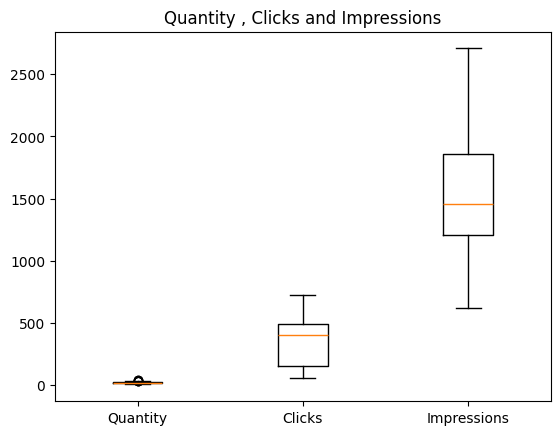

In [ ]:
plt.figure(3)
plt.boxplot([product_clicks_impression['Quantity'], product_clicks_impression['Clicks'], product_clicks_impression['Impressions']])
plt.title('Quantity , Clicks and Impressions')
plt.xticks([1,2,3], ['Quantity', 'Clicks', 'Impressions'])
plt.show()

- Quantity has outliers

### Imputing Data and Removing Outliers

##### IQR, 95 Percentile and 5 Percentile

In [ ]:
Q1 = np.percentile(product_clicks_impression['Quantity'], 25)
Q3 = np.percentile(product_clicks_impression['Quantity'], 75)
p_95 = np.percentile(product_clicks_impression['Quantity'], 95)
p_96 = np.percentile(product_clicks_impression['Quantity'], 96)
p_97 = np.percentile(product_clicks_impression['Quantity'], 97)
p_98 = np.percentile(product_clicks_impression['Quantity'], 98)
p_99 = np.percentile(product_clicks_impression['Quantity'], 99)
p_5 = np.percentile(product_clicks_impression['Quantity'], 5)
IQR = Q3 - Q1
quantity_mean = product_clicks_impression['Quantity'].mean()
quantity_mode = product_clicks_impression['Quantity'].mode()[0]
quantity_median = product_clicks_impression['Quantity'].median()

print(f"Mean : {quantity_mean}")
print(f"Mode : {quantity_mode}")
print(f"Median : {quantity_median}")
print('-------------------------------------')
print(f"Q1: {Q1}")
print(f"Q3: {Q3}")
print(f"IQR: {IQR}")
print('-------------------------------------')
print(f"5 -Percentile value: {p_5}")
print(f"95-Percentile value: {p_95}")
print(f"96-Percentile value: {p_96}")
print(f"97-Percentile value: {p_97}")
print(f"98-Percentile value: {p_98}")
print(f"99-Percentile value: {p_99}")


Mean : 17.54245283018868
Mode : 15
Median : 17.0
-------------------------------------
Q1: 13.75
Q3: 21.0
IQR: 7.25
-------------------------------------
5 -Percentile value: 9.0
95-Percentile value: 27.44999999999999
96-Percentile value: 28.560000000000002
97-Percentile value: 30.669999999999987
98-Percentile value: 31.78
99-Percentile value: 35.66999999999996


##### Replacing outliers with - 95 & 5 Percentile values

In [ ]:
product_clicks_impression['Quantity_new_95_5'] = product_clicks_impression['Quantity'].apply(lambda x: removeOutlierFunction(x, p_5, p_95,p_5, p_95))

##### Replacing outliers with - 97 & 5 Percentile values

In [ ]:
product_clicks_impression['Quantity_new_97_5'] = product_clicks_impression['Quantity'].apply(lambda x: removeOutlierFunction(x, p_5, p_97,p_5, p_97))

#### After removing or imputing Outliers & Shift in Data frequency

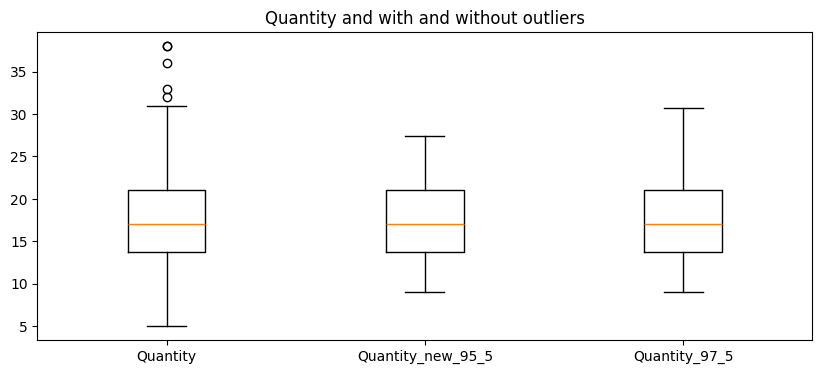

In [ ]:
quantityTitles = [product_clicks_impression['Quantity'], product_clicks_impression['Quantity_new_95_5'],product_clicks_impression['Quantity_new_97_5']]
plt.figure(3,figsize=(10,4))
plt.boxplot(quantityTitles)
plt.title('Quantity and with and without outliers')
plt.xticks([1,2,3], ['Quantity', 'Quantity_new_95_5', 'Quantity_97_5'])
plt.show()

**Note:**
- The `Quantity_new_95_5` and `Quantity_97_5` column values which are greater than **95-Percentile** and **97-Percentile** are repalced by **95-Percentile** and **97-Percentile** respectively

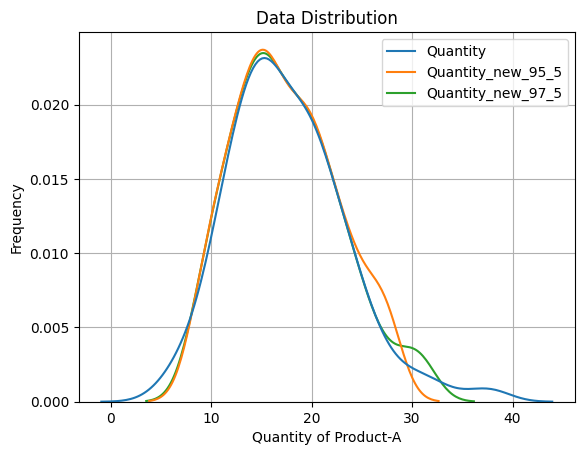

In [ ]:
sns.kdeplot(quantityTitles)
plt.title('Data Distribution')
plt.xlabel('Quantity of Product-A')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

**Note:**
- `Quantity` feature is more normalized after outlier imputation and removal

### Feature Engineering

In [ ]:
product_clicks_impression_update = product_clicks_impression.copy(True)
product_clicks_impression_update['Day Index'] = pd.to_datetime(product_clicks_impression_update['Day Index'])
product_clicks_impression_update['Weekday'] = product_clicks_impression_update['Day Index'].dt.day_name()
product_clicks_impression_update['Week'] = product_clicks_impression_update['Day Index'].dt.isocalendar().week
product_clicks_impression_update['Week'] = product_clicks_impression_update['Week'].astype(str)
product_clicks_impression_update['Month'] = product_clicks_impression_update['Day Index'].dt.month_name()
# product_clicks_impression_update['Quater'] = product_clicks_impression_update['Day Index'].dt.quarter
# product_clicks_impression_update['Quater'] = product_clicks_impression_update['Quater'].astype(str)
def get_season(date):
    if date.month in [12, 1, 2]:
        return 'Winter'
    elif date.month in [3, 4, 5]:
        return 'Spring'
    elif date.month in [6, 7, 8]:
        return 'Summer'
    elif date.month in [9, 10, 11]:
        return 'Fall'
product_clicks_impression_update['Season'] = product_clicks_impression_update['Day Index'].apply(get_season)
product_clicks_impression_update['Weekday'] = product_clicks_impression_update['Day Index'].dt.day_name()
product_clicks_impression_update['Is_Weekend'] = product_clicks_impression_update['Weekday'].isin(['Saturday', 'Sunday'])
product_clicks_impression_update['Is_Weekday'] = ~product_clicks_impression_update['Is_Weekend']

product_clicks_impression_update_partical_copy = product_clicks_impression_update.copy(True)
del product_clicks_impression_update_partical_copy['Weekday']
del product_clicks_impression_update_partical_copy['Month']
product_clicks_impression_update_partical_copy['Weekday1'] = product_clicks_impression_update_partical_copy['Day Index'].dt.day_of_week
product_clicks_impression_update_partical_copy['Month1'] = product_clicks_impression_update_partical_copy['Day Index'].dt.month
print("Shape before encoding:", product_clicks_impression_update.shape)
product_clicks_impression_update = pd.get_dummies(product_clicks_impression_update, columns=['Weekday', 'Week', 'Month','Season'])
print("Shape after encoding:", product_clicks_impression_update.shape)
# product_clicks_impression_update.head()

Shape before encoding: (212, 12)
Shape after encoding: (212, 56)


In [ ]:
bool_columns = product_clicks_impression_update.select_dtypes(include=['bool']).columns
product_clicks_impression_update[bool_columns] = product_clicks_impression_update[bool_columns].astype(int)
product_clicks_impression_update.head()

,Day Index,Quantity,Clicks,Impressions,Quantity_new_95_5,Quantity_new_97_5,Is_Weekend,Is_Weekday,Weekday_Friday,Weekday_Monday,...,Month_April,Month_December,Month_February,Month_January,Month_June,Month_March,Month_May,Season_Spring,Season_Summer,Season_Winter
0,2021-12-01,14,445,620,14.00,14.00,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
1,2021-12-02,10,433,890,10.00,10.00,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
2,2021-12-03,13,424,851,13.00,13.00,0,1,1,0,...,0,1,0,0,0,0,0,0,0,1
3,2021-12-04,22,427,881,22.00,22.00,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,2021-12-05,33,451,678,27.45,30.67,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [ ]:
product_clicks_impression_update.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 56 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Day Index          212 non-null    datetime64[ns]
 1   Quantity           212 non-null    int64         
 2   Clicks             212 non-null    int64         
 3   Impressions        212 non-null    int64         
 4   Quantity_new_95_5  212 non-null    float64       
 5   Quantity_new_97_5  212 non-null    float64       
 6   Is_Weekend         212 non-null    int64         
 7   Is_Weekday         212 non-null    int64         
 8   Weekday_Friday     212 non-null    int64         
 9   Weekday_Monday     212 non-null    int64         
 10  Weekday_Saturday   212 non-null    int64         
 11  Weekday_Sunday     212 non-null    int64         
 12  Weekday_Thursday   212 non-null    int64         
 13  Weekday_Tuesday    212 non-null    int64         
 14  Weekday_We

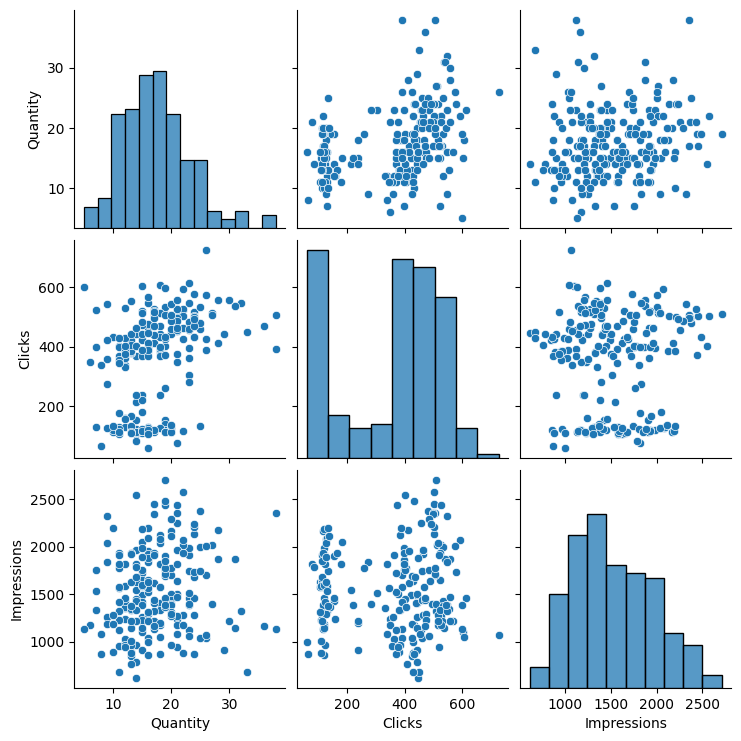

In [ ]:
# prompt: generate pairplot for important features for visualization of dataframe

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'product_clicks_impression_update' is your DataFrame
# and you want to visualize 'Quantity', 'Clicks', and 'Impressions'

important_features = ['Quantity', 'Clicks', 'Impressions']
sns.pairplot(product_clicks_impression_update[important_features])
plt.show()

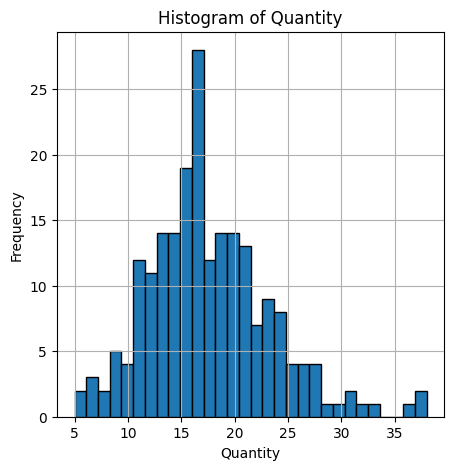

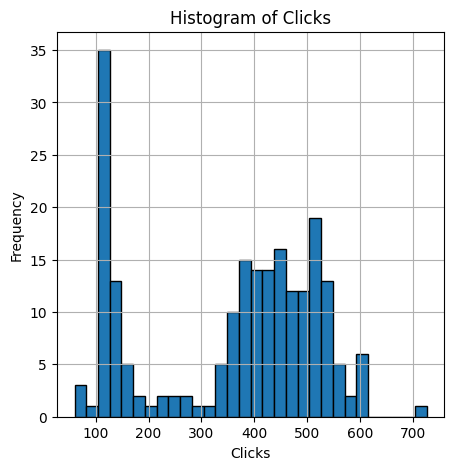

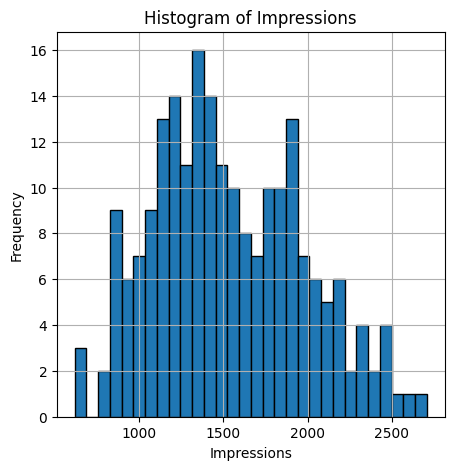

In [ ]:
# prompt: generate histogram for features

# Assuming 'product_clicks_impression_update' is your DataFrame
# and you want to visualize 'Quantity', 'Clicks', and 'Impressions'

important_features = ['Quantity', 'Clicks', 'Impressions']

# Create histograms for each feature
for feature in important_features:
    plt.figure(figsize=(5,5))  # Adjust figure size if needed
    plt.hist(product_clicks_impression_update[feature], bins=30, edgecolor='black') # Adjust bins as needed
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {feature}')
    plt.grid(True)
    plt.show()

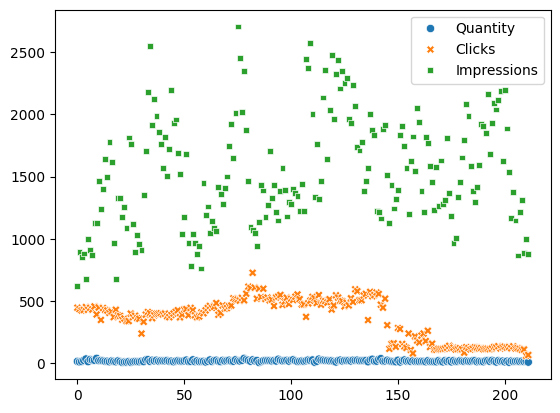

In [ ]:
# prompt: generate scatter plot for important features

# Assuming 'product_clicks_impression_update' is your DataFrame
# and you want to visualize 'Quantity', 'Clicks', and 'Impressions'

important_features = ['Quantity', 'Clicks', 'Impressions']

# Create a scatter plot matrix
sns.scatterplot(product_clicks_impression_update[important_features])
plt.show()

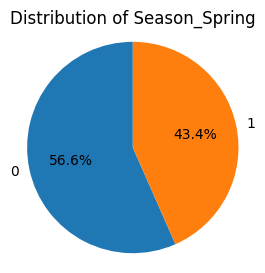

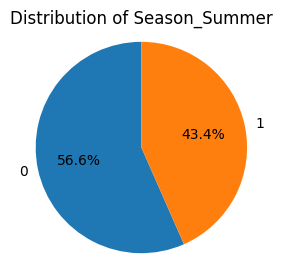

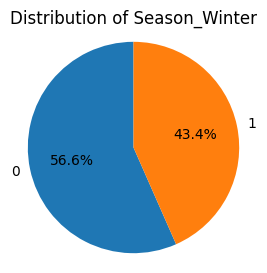

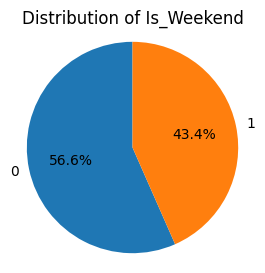

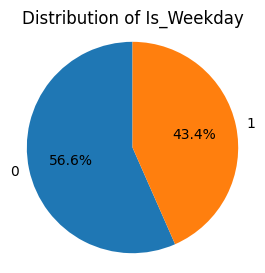

In [ ]:
# prompt: visualise important categorical features in dataframe using pie chart

import matplotlib.pyplot as plt

# Assuming 'product_clicks_impression_update' is your DataFrame
# and you want to visualize categorical features like 'Season' or 'Weekday'

def plot_categorical_feature(df, column_name):
    """Plots a pie chart for a given categorical column in a DataFrame.

    Args:
        df: The pandas DataFrame containing the data.
        column_name: The name of the categorical column to visualize.
    """

    feature_counts = df['Season_Spring'].value_counts()
    plt.figure(figsize=(3,3))
    plt.pie(feature_counts.values, labels=feature_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title(f'Distribution of {column_name}')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

# Example usage (replace with your actual categorical column names):
plot_categorical_feature(product_clicks_impression_update, 'Season_Spring')
plot_categorical_feature(product_clicks_impression_update, 'Season_Summer')
plot_categorical_feature(product_clicks_impression_update, 'Season_Winter')
plot_categorical_feature(product_clicks_impression_update, 'Is_Weekend')
plot_categorical_feature(product_clicks_impression_update, 'Is_Weekday')

### How Quantity, Impressions and Clicks are related:

#### Impressions vs Quantity

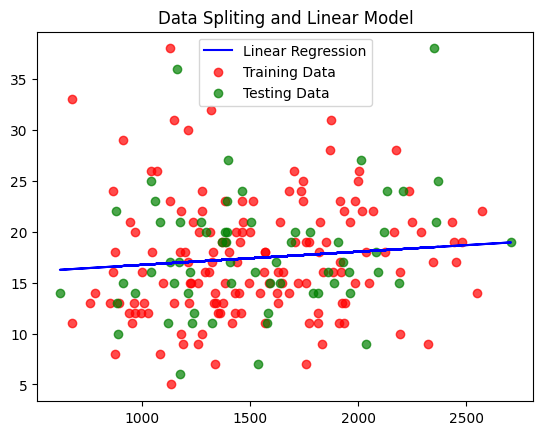

R-square or Score: 0.030818889727113108
Slope            : [0.00128878]


In [ ]:
LRModelResult(X = product_clicks_impression['Impressions'],y = product_clicks_impression['Quantity'])

#### Clicks vs Quantity

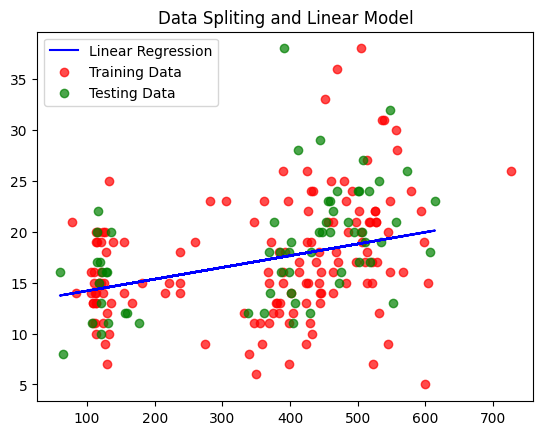

R-square or Score: 0.16923384377047157
Slope            : [0.0115248]


In [ ]:
LRModelResult(X = product_clicks_impression['Clicks'],y = product_clicks_impression['Quantity'])

#### Impressions vs Clicks

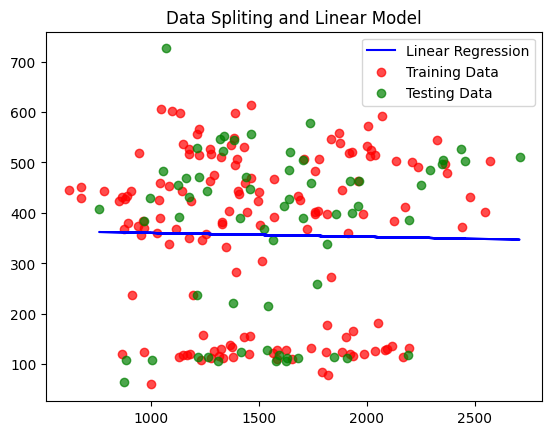

R-square or Score: -0.00821411712185749
Slope            : [-0.00773371]


In [ ]:
LRModelResult(X = product_clicks_impression['Impressions'],y = product_clicks_impression['Clicks'])

### Correlation:

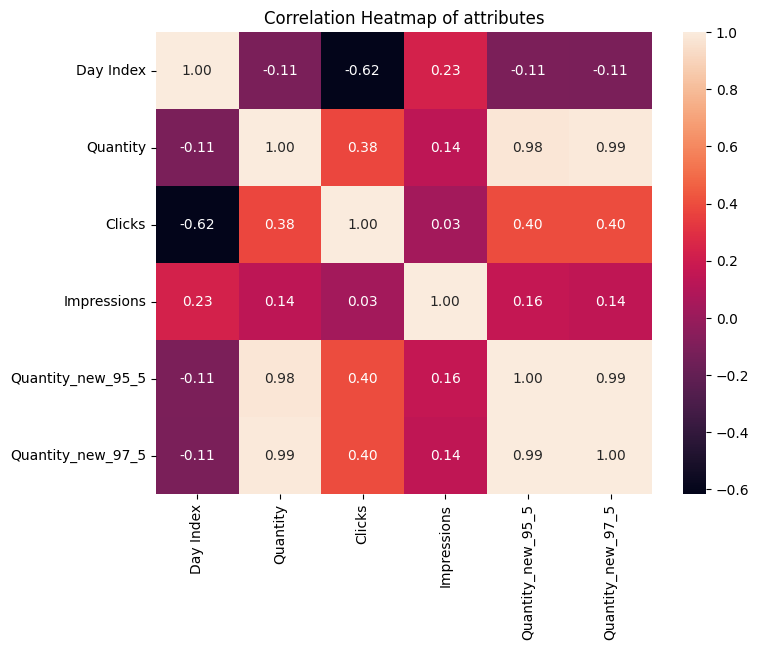

In [ ]:
correlation_matrix = product_clicks_impression.corr("pearson")
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Correlation Heatmap of attributes')
plt.show()

**Note:**
- Positive increase in correlation between `Quantity`,`Quantity_new_95_5`, `Quantity_new_97_5` and `Clicks`
- Similar goes for correlation between `Quantity` , `Quantity_new_95_5` and `Impressions`

### Data visualization

#### Daily

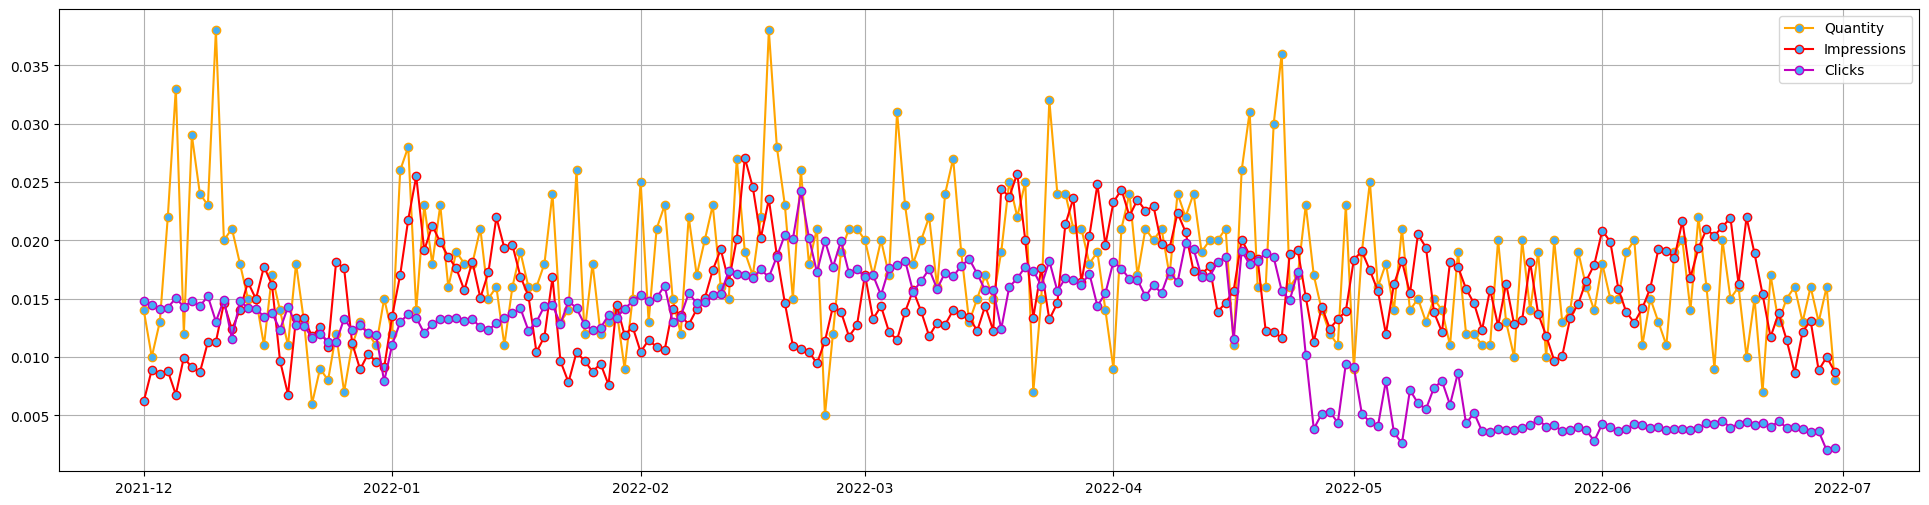

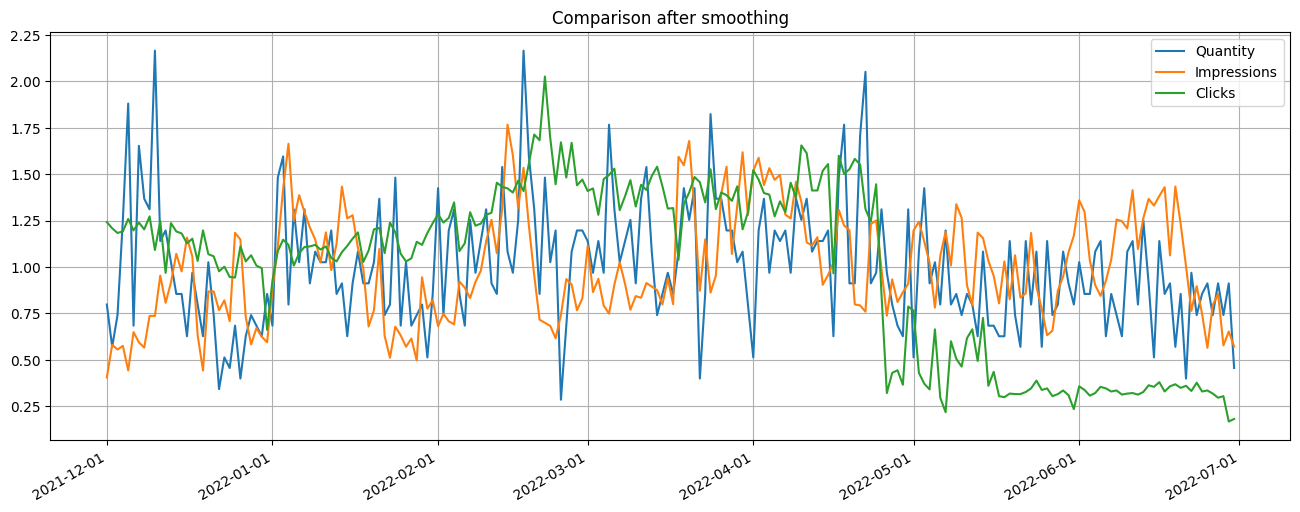

In [ ]:
daily()

#### Week-Days

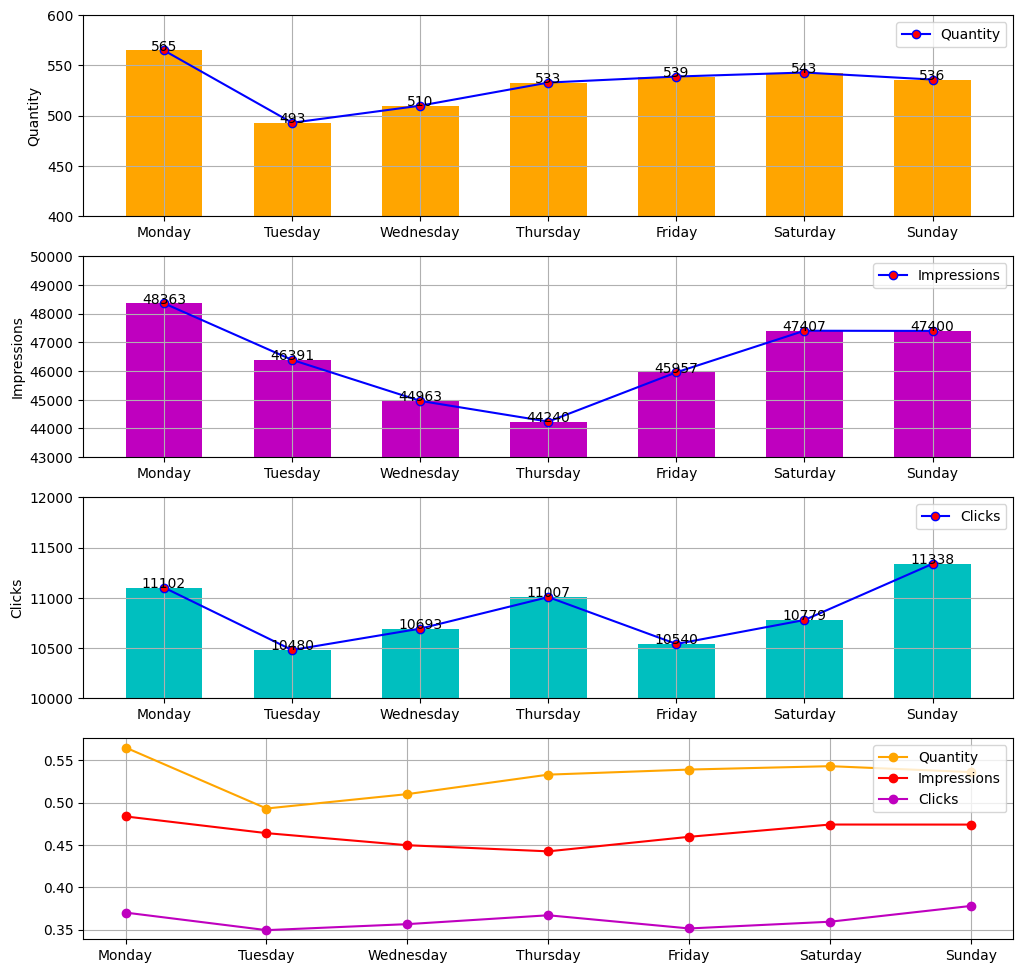

In [ ]:
weekDays = weekdays()

**Note:**
- `Monday` to `Thursday` Quantity follow similar pattern as Clicks
- Similarly from `Thursday` to `Sunday` Quantity follows pattern as Impressions
- Strong positive correlation between all the three i.e.
    - Between Quantity and Clicks
    - Between Quantity and Impressions
    - Between Clicks and Impressions

#### Weekly

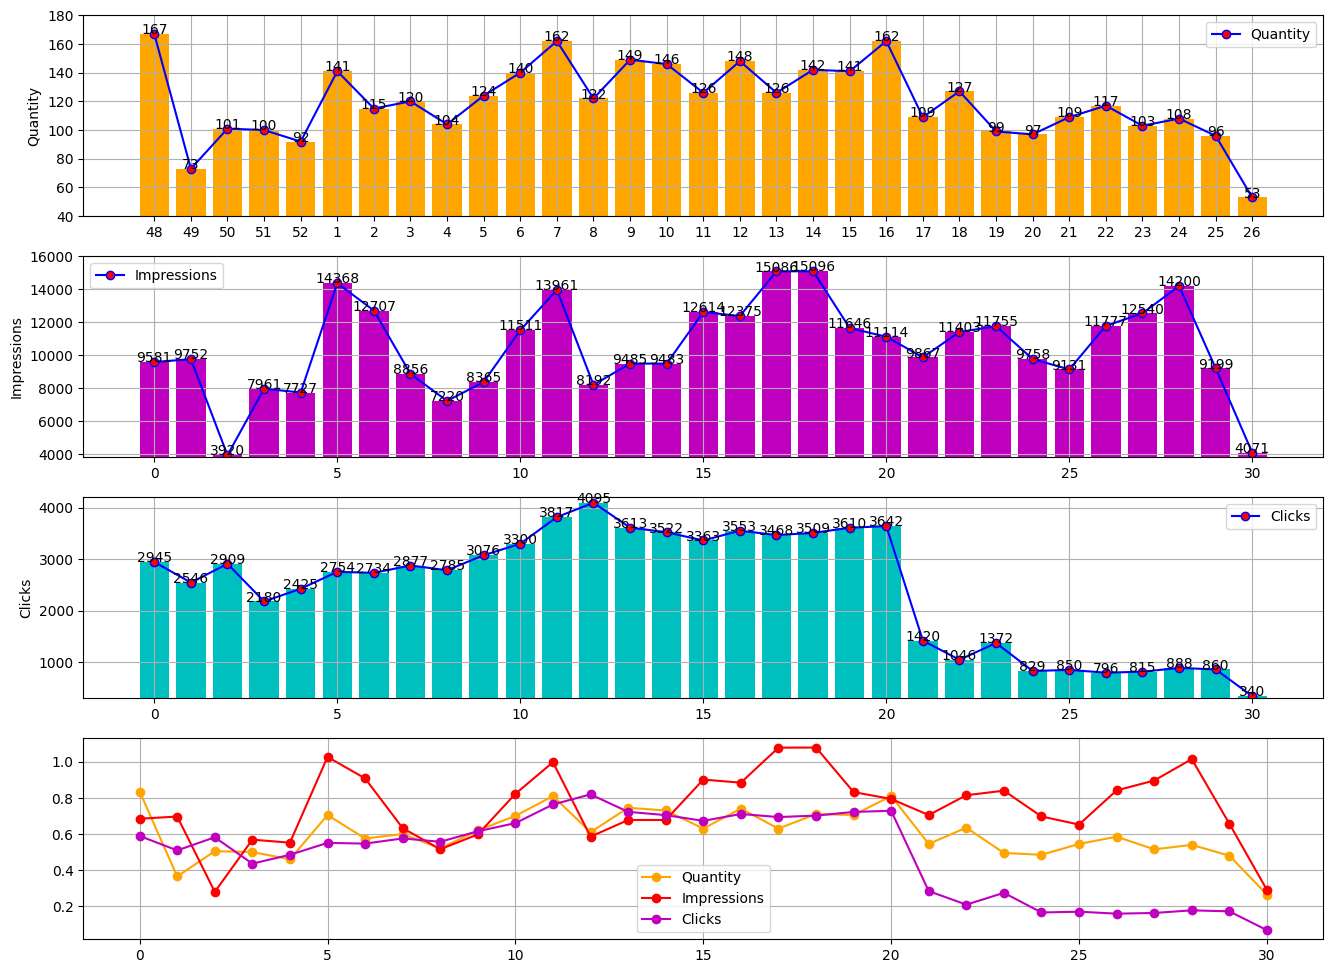

In [ ]:
weekWiseData = weekwise()

**Note:**
- We can observe that from `WEEK-1` to `WEEK-14` Qunatity and Impressions have same pattern
- Similarly from `WEEK-14` to `WEEK-21` Qunatity and Clicks follow same pattern
- After `WEEK-27` Quantity, Impressions and Clicks falls.
- Relation between `Quantity` and `Clicks` has improved
- There is low `negative` in correlation between `Quantity` and `Impressions` & `Clicks` and `Impressions`

#### Monthly

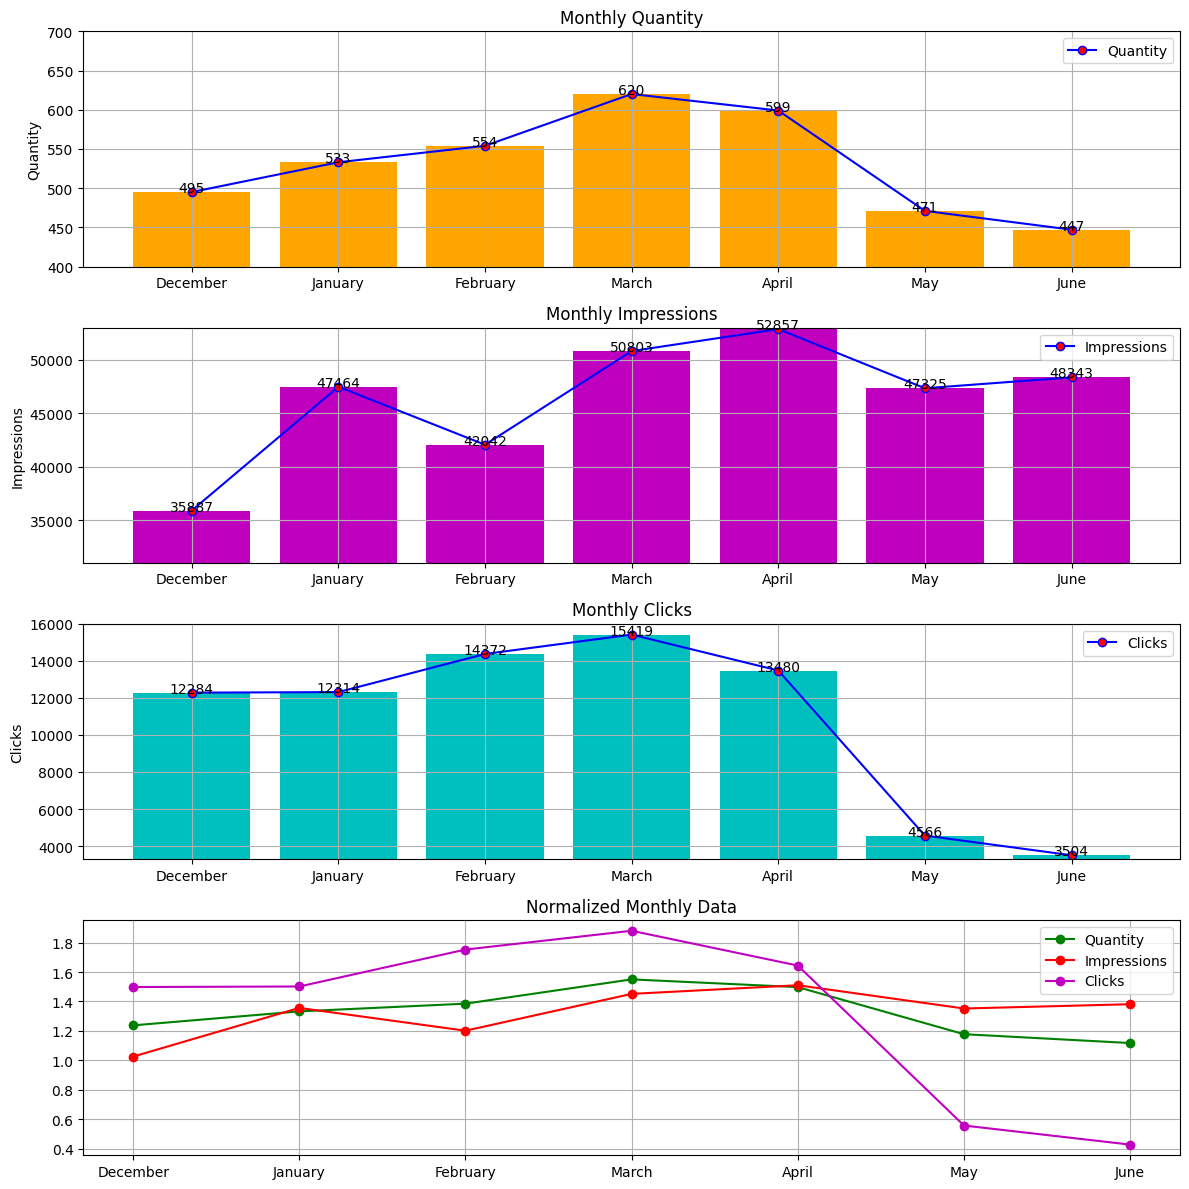

In [ ]:
monthlyData = months(product_clicks_impression)

**Note:**
- `Quantity` and `Clicks` show same behaviour over 7 months
- Last 2 month `Quantity`, `Impressions` and `Clicks` fall

### Hypothesis Testing

We can check stationarity of data by following ways:
1. Visualisation
2. Statistical Tests:
    1. *ADF Test*
    2. *KPSS Test*
- Conclusions that can be drawn from Statistical Tests:
    - `Case 1`: **Both** tests conclude that the given series is **stationary** – The series is `stationary`
    - `Case 2`: **Both** tests conclude that the given series is **non-stationary** – The series is `non-stationary`
    - `Case 3`: ADF concludes **non-stationary**, and KPSS concludes **stationary** – The series is `trend stationary`.
    - `Case 4`: ADF concludes **stationary**, and KPSS concludes **non-stationary** – The series is `difference stationary`.

#### 1. Stationarity

##### 1.1 Quantity

In [ ]:
print(adf_test(product_clicks_impression['Quantity']))
print(kpss_test(product_clicks_impression['Quantity']))

Results of Dickey-Fuller Test:
Test Statistic                  -4.445717
p-value                          0.000246
#Lags Used                       3.000000
Number of Observations Used    208.000000
Critical Value (1%)             -3.462186
Critical Value (5%)             -2.875538
Critical Value (10%)            -2.574231
dtype: float64
None
Results of KPSS Test:
Test Statistic           0.322623
p-value                  0.100000
#Lags Used               7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
None


- `Quantity` data is stationary.

##### 1.2 Impressions

In [ ]:
print(adf_test(product_clicks_impression['Impressions']))
print(kpss_test(product_clicks_impression['Impressions']))

Results of Dickey-Fuller Test:
Test Statistic                -5.696206e+00
p-value                        7.863580e-07
#Lags Used                     0.000000e+00
Number of Observations Used    2.110000e+02
Critical Value (1%)           -3.461727e+00
Critical Value (5%)           -2.875337e+00
Critical Value (10%)          -2.574124e+00
dtype: float64
None
Results of KPSS Test:
Test Statistic           0.351808
p-value                  0.097928
#Lags Used               8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
None


- `Impressions` data is stationary.

##### 1.3 Clicks

In [ ]:
print(adf_test(product_clicks_impression['Clicks']))
print(kpss_test(product_clicks_impression['Clicks']))

Results of Dickey-Fuller Test:
Test Statistic                  -0.870572
p-value                          0.797509
#Lags Used                       2.000000
Number of Observations Used    209.000000
Critical Value (1%)             -3.462032
Critical Value (5%)             -2.875471
Critical Value (10%)            -2.574195
dtype: float64
None
Results of KPSS Test:
Test Statistic           1.171045
p-value                  0.010000
#Lags Used               9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
None


- `Clicks` data is non-stationary.

Converting Non-Stationary Data into Stationary Data

In [ ]:
product_clicks_impression_update['Clicks_diff_1'] = product_clicks_impression_update['Clicks'].diff(1)
product_clicks_impression_update['Clicks_diff_1'][0] = 0
product_clicks_impression_update['Clicks_diff_2'] = product_clicks_impression_update['Clicks'].diff(2)
product_clicks_impression_update['Clicks_diff_2'][0] = 0
product_clicks_impression_update['Clicks_diff_2'][1] = -12

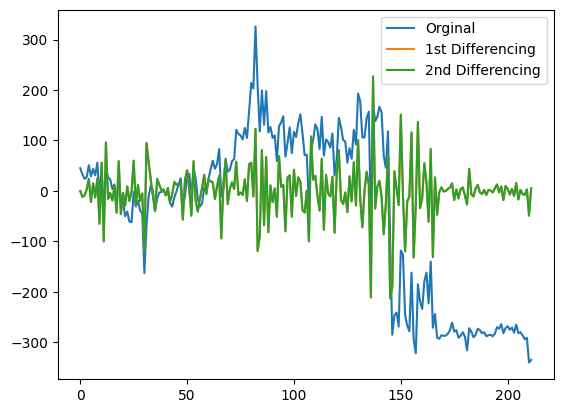

Results of Dickey-Fuller Test:
Test Statistic                  -4.144415
p-value                          0.000817
#Lags Used                      15.000000
Number of Observations Used    196.000000
Critical Value (1%)             -3.464161
Critical Value (5%)             -2.876402
Critical Value (10%)            -2.574692
dtype: float64
None
Results of KPSS Test:
Test Statistic           0.135368
p-value                  0.100000
#Lags Used               4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
None


,Day Index,Quantity,Clicks,Impressions,Quantity_new_95_5,Quantity_new_97_5,Clicks_diff_1,Clicks_diff_2
0,2021-12-01,14,445,620,14.00,14.00,0.0,0.0
1,2021-12-02,10,433,890,10.00,10.00,-12.0,-12.0
2,2021-12-03,13,424,851,13.00,13.00,-9.0,-21.0
3,2021-12-04,22,427,881,22.00,22.00,3.0,-6.0
4,2021-12-05,33,451,678,27.45,30.67,24.0,27.0


In [ ]:
product_clicks_impression['Clicks_diff_1'] = product_clicks_impression['Clicks'].diff(1)
product_clicks_impression['Clicks_diff_1'][0] = 0
product_clicks_impression['Clicks_diff_2'] = product_clicks_impression['Clicks'].diff(2)
product_clicks_impression['Clicks_diff_2'][0] = 0
product_clicks_impression['Clicks_diff_2'][1] = -12

plt.plot(product_clicks_impression.index, product_clicks_impression['Clicks'].sub(400), label = 'Orginal')
plt.plot(product_clicks_impression.index, product_clicks_impression['Clicks_diff_1'], label = '1st Differencing')
plt.plot(product_clicks_impression.index, product_clicks_impression['Clicks_diff_1'], label = '2nd Differencing')
plt.legend()
plt.show()
print(adf_test(product_clicks_impression['Clicks_diff_2']))
print(kpss_test(product_clicks_impression['Clicks_diff_2']))
product_clicks_impression.head()

- `Clicks` data achives stationarity after `2nd` order differencing

#### 2. Trend and Seasonality

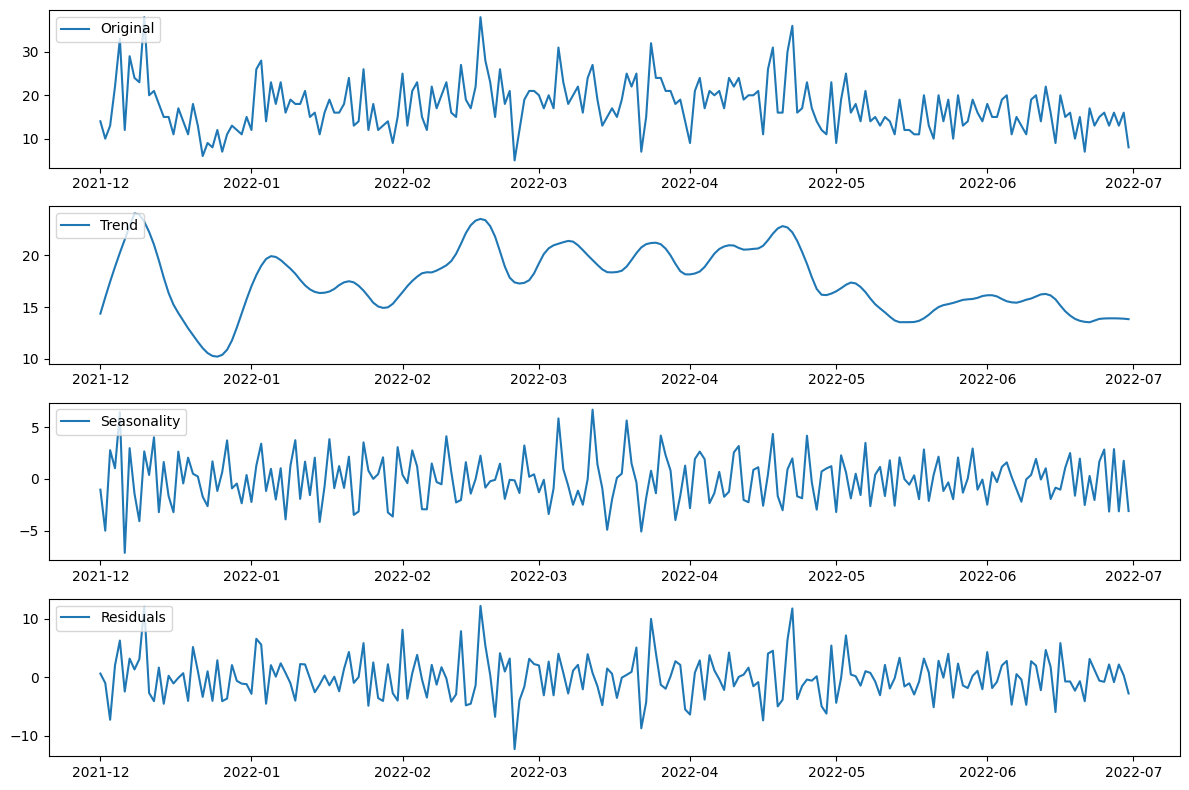

In [ ]:
product_clicks_impression_update_1 = product_clicks_impression.set_index('Day Index')
seasonal_period = 7
stl = STL(product_clicks_impression_update_1['Quantity'], seasonal=seasonal_period)
result = stl.fit()
# Plotting the components
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(product_clicks_impression_update_1['Quantity'], label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonality')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Residuals')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
!pip install pymannkendall
import pymannkendall as mk
mk.original_test(product_clicks_impression['Quantity'])

Mann_Kendall_Test(trend='no trend', h=False, p=0.1479645859286245, z=-1.446758456124471, Tau=-0.06670839667352231, s=-1492.0, var_s=1062094.6666666667, slope=-0.0078125, intercept=17.82421875)

In [ ]:
import pymannkendall as mk
mk.original_test(product_clicks_impression['Quantity'])

Mann_Kendall_Test(trend='no trend', h=False, p=0.1479645859286245, z=-1.446758456124471, Tau=-0.06670839667352231, s=-1492.0, var_s=1062094.6666666667, slope=-0.0078125, intercept=17.82421875)

- `No` Trend found in Quantity

#### 3. Lagged Effects over Quantity

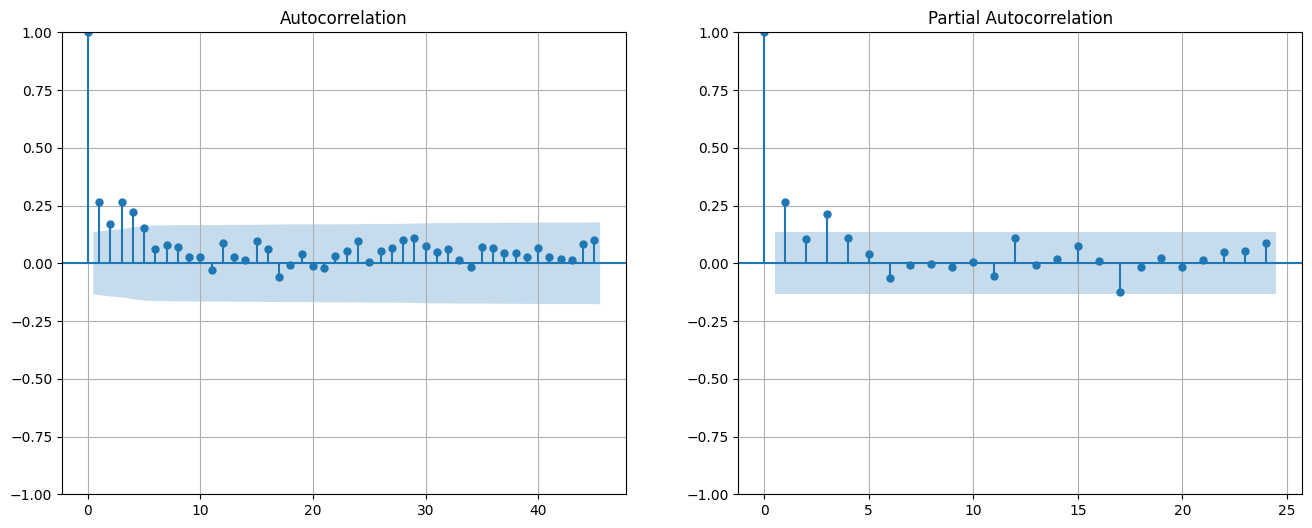

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(product_clicks_impression['Quantity'], lags=45, ax=axes[0])
axes[0].grid(True)
plot_pacf(product_clicks_impression['Quantity'], ax=axes[1])
plt.grid(True)
plt.show()

- ACF Lag - `1`, `3`, `4`
- PACF Lags - `1`, `3`

### Split Ratio for Model Training & Evaluation

Dataset For | Split Ratio-1 | Split Ratio-2
--- | --- | --- |
Training | 60% | 80%|
Validating | 20% | 10%
Testing | 20% | 10%|

### Basic Time Series Models

#### Auto Regression (AR) Model

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Function for ARIMA model with validation and test data evaluation
def AR_MA_ARIMA_Model_TestingAndValidation(p, d, q, Dataframe, col, trainDataSize, testDataSize):
    # Split the data
    train_size = int(len(Dataframe) * trainDataSize)
    test_size = int(len(Dataframe) * testDataSize)

    train = Dataframe[col][:train_size]
    validation = Dataframe[col][train_size:train_size + test_size]
    test = Dataframe[col][train_size + test_size:]

    # Fit the ARIMA model
    model = ARIMA(train, order=(p, d, q))
    model_fit = model.fit()

    # Forecast validation data
    validation_forecast = model_fit.forecast(steps=len(validation))

    # Forecast test data from the model refit on the entire train + validation data
    model_full = ARIMA(pd.concat([train, validation]), order=(p, d, q)).fit()
    test_forecast = model_full.forecast(steps=len(test))

    # Calculate validation metrics
    validation_mae = mean_absolute_error(validation, validation_forecast)
    validation_rmse = mean_squared_error(validation, validation_forecast, squared=False)
    validation_mape = np.mean(np.abs((validation - validation_forecast) / validation))  # MAPE

    valid_r_2 = r2_score(validation, validation_forecast)
    valid_adjusted_r_2 = 1 - (1 - valid_r_2) * (len(validation) - 1) / (len(validation) - len(validation_forecast) - 1)

    # Calculate test metrics
    test_mae = mean_absolute_error(test, test_forecast)
    test_rmse = mean_squared_error(test, test_forecast, squared=False)
    test_mape = np.mean(np.abs((test - test_forecast) / test))  # MAPE

    test_r_2 = r2_score(test, test_forecast)
    test_adjusted_r_2 = 1 - (1 - test_r_2) * (len(test) - 1) / (len(test) - len(test_forecast) - 1)

    # Print validation and test results
    print('Validation Data:')
    print(f'MAE: {round(validation_mae, 4)}, RMSE: {round(validation_rmse, 4)}, MAPE: {round(validation_mape * 100, 4)}%, '
          f'R-Square: {round(valid_r_2, 4)}, Adjusted R-Square: {round(valid_adjusted_r_2, 4)}')

    print('Test Data:')
    print(f'MAE: {round(test_mae, 4)}, RMSE: {round(test_rmse, 4)}, MAPE: {round(test_mape * 100, 4)}%, '
          f'R-Square: {round(test_r_2, 4)}, Adjusted R-Square: {round(test_adjusted_r_2, 4)}')

# Usage example
#AR = AR_MA_ARIMA_Model_TestingAndValidation(1, 0, 0, product_clicks_impression, 'Quantity', 0.60, 0.20)


In [ ]:
AR = AR_MA_ARIMA_Model_TestingAndValidation(1,0,0,product_clicks_impression,'Quantity', 0.60, 0.20)

Validation Data:
MAE: 4.782, RMSE: 5.9462, MAPE: 29.2645%, R-Square: 0.0007, Adjusted R-Square: 41.9726
Test Data:
MAE: 3.936, RMSE: 4.7451, MAPE: 33.1604%, R-Square: -0.7117, Adjusted R-Square: 72.8919


In [ ]:
AR = AR_MA_ARIMA_Model_TestingAndValidation(1,0,0,product_clicks_impression,'Quantity', 0.80, 0.10)

Validation Data:
MAE: 3.5379, RMSE: 4.1853, MAPE: 26.9987%, R-Square: -0.5928, Adjusted R-Square: 32.8555
Test Data:
MAE: 4.1029, RMSE: 4.9749, MAPE: 37.0619%, R-Square: -0.6841, Adjusted R-Square: 36.3658


#### Moving Average (MA) Model

In [ ]:
MA = AR_MA_ARIMA_Model_TestingAndValidation(0,0,1,product_clicks_impression,'Quantity', 0.60, 0.20)

Validation Data:
MAE: 4.7876, RMSE: 5.9497, MAPE: 29.2973%, R-Square: -0.0005, Adjusted R-Square: 42.0212
Test Data:
MAE: 3.9466, RMSE: 4.7642, MAPE: 33.2965%, R-Square: -0.7255, Adjusted R-Square: 73.4712


In [ ]:
MA = AR_MA_ARIMA_Model_TestingAndValidation(0,0,1,product_clicks_impression,'Quantity', 0.80, 0.10)

Validation Data:
MAE: 3.5503, RMSE: 4.2173, MAPE: 27.1958%, R-Square: -0.6172, Adjusted R-Square: 33.3443
Test Data:
MAE: 4.0964, RMSE: 4.9833, MAPE: 37.0783%, R-Square: -0.6898, Adjusted R-Square: 36.4849


#### Auto Regression Integrated Moving Average (ARIMA) Model

In [ ]:
AR = AR_MA_ARIMA_Model_TestingAndValidation(1,0,1,product_clicks_impression,'Quantity', 0.60, 0.20)

Validation Data:
MAE: 4.7468, RMSE: 5.9204, MAPE: 29.086%, R-Square: 0.0093, Adjusted R-Square: 41.6181
Test Data:
MAE: 3.8176, RMSE: 4.5539, MAPE: 31.7497%, R-Square: -0.5765, Adjusted R-Square: 67.2148


In [ ]:
AR = AR_MA_ARIMA_Model_TestingAndValidation(1,0,1,product_clicks_impression,'Quantity', 0.80, 0.10)

Validation Data:
MAE: 3.3717, RMSE: 3.838, MAPE: 24.796%, R-Square: -0.3394, Adjusted R-Square: 27.7876
Test Data:
MAE: 4.0016, RMSE: 4.844, MAPE: 35.736%, R-Square: -0.5966, Adjusted R-Square: 34.5293


#### Seasonal Auto Regression Intergrated Moving Average (SARIMA) Model

In [ ]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def SARIMA_Model(Dataframe, p, d, q, ratioTest, ratioValidate, attributeQ, SOp, SOd, SOq, SOseason):
    # Split the data into train, validation, and test sets based on the ratios
    train_size = int(len(Dataframe) * (1 - ratioTest - ratioValidate))
    validate_size = int(len(Dataframe) * ratioValidate)

    train = Dataframe[attributeQ][:train_size]
    validate = Dataframe[attributeQ][train_size:train_size + validate_size]
    test = Dataframe[attributeQ][train_size + validate_size:]

    # Fit the SARIMA model
    model = SARIMAX(train, order=(p, d, q), seasonal_order=(SOp, SOd, SOq, SOseason))
    model_fit = model.fit(disp=False)

    # Forecast validation data
    validate_forecast = model_fit.forecast(steps=len(validate))

    # Calculate validation metrics
    valid_mae = mean_absolute_error(validate, validate_forecast)
    valid_rmse = mean_squared_error(validate, validate_forecast, squared=False)
    valid_mape = np.mean(np.abs((validate - validate_forecast) / validate))

    valid_r_2 = r2_score(validate, validate_forecast)
    valid_adjusted_r_2 = 1 - (1 - valid_r_2) * (len(validate) - 1) / (len(validate) - len(validate_forecast) - 1)

    # Convert metrics to np.float64 if necessary (optional, for consistency)
    valid_mae = np.float64(valid_mae)
    valid_rmse = np.float64(valid_rmse)
    valid_mape = np.float64(valid_mape)
    valid_r_2 = np.float64(valid_r_2)
    valid_adjusted_r_2 = np.float64(valid_adjusted_r_2)

    # Print validation results
    print('Validation Data:')
    print(f'MAE: {valid_mae.round(4)}, RMSE: {valid_rmse.round(4)}, MAPE: {(valid_mape * 100).round(4)}%, '
          f'R-square: {valid_r_2.round(4)}, Adjusted R-square: {valid_adjusted_r_2.round(4)}')

    #... (Rest of the function, e.g., test set evaluation) ...

# Usage example
# Ensure `product_clicks_impression_update` is a DataFrame and `'Quantity'` is a column within it
SARIMA_Model(product_clicks_impression_update, 1, 0, 1, 0.60, 0.20, 'Quantity', 0, 0, 0, 12)


Validation Data:
MAE: 5.9005, RMSE: 8.0209, MAPE: 28.5336%, R-square: -1.0315, Adjusted R-square: 84.2899


In [ ]:
SARIMA_Model(product_clicks_impression_update, 1, 0, 1, 0.60, 0.20, 'Quantity',0, 0, 0, 12)

Validation Data:
MAE: 5.9005, RMSE: 8.0209, MAPE: 28.5336%, R-square: -1.0315, Adjusted R-square: 84.2899


In [ ]:
SARIMA_Model(product_clicks_impression_update, 1, 0, 1, 0.80,0.10, 'Quantity',0, 0, 0, 12)

Validation Data:
MAE: 6.2405, RMSE: 7.9095, MAPE: 40.9054%, R-square: -0.7395, Adjusted R-square: 35.7908


#### Auto ARIMA

In [ ]:
!pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.8 MB/s eta 0:00:00


In [ ]:
from pmdarima import auto_arima
train_data = product_clicks_impression['Quantity']
model = auto_arima(train_data, seasonal=False, trace=True)
print(model.summary())
forecasts = model.predict()
print(forecasts)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1339.010, Time=1.91 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1840.056, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1423.427, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1668.562, Time=0.68 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1337.554, Time=1.28 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1595.146, Time=1.21 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1337.602, Time=1.69 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1339.535, Time=5.03 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1549.998, Time=2.49 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1337.521, Time=4.56 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1386.038, Time=1.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1339.403, Time=4.16 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1353.871, Time=3.44 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1340.924, Time=6.52 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept

- Auto ARIMA also prefers lag values as `p = 1` and `q = 1`

#### Autoregressive Integrated Moving Average with Explanatory Variable (ARIMAX) Model

In [ ]:
def ARIMAX_Model(p,d,q,Dataframe, col,exog_cols, trainDataSize, testDataSize):
    product_clicks_impression_temp = Dataframe.copy()
    product_clicks_impression_temp = Dataframe.set_index('Day Index')
    train_size = int(trainDataSize * len(product_clicks_impression_temp))
    validation_size = int(testDataSize * len(product_clicks_impression_temp))

    train_data = product_clicks_impression_temp.iloc[:train_size][col]
    validation_data = product_clicks_impression_temp.iloc[train_size:train_size+validation_size][col]
    test_data = product_clicks_impression_temp.iloc[train_size+validation_size:][col]

    # ARIMAX Model
    order = (p, d, q)
    exog_data = product_clicks_impression_temp.iloc[:train_size][exog_cols]
    exog_data_valid = product_clicks_impression_temp.iloc[train_size:train_size+validation_size][exog_cols]
    exog_data_test = product_clicks_impression_temp.iloc[train_size+validation_size:][exog_cols]
    arima_model = ARIMA(train_data, order=order,exog=exog_data)
    arima_result = arima_model.fit()

    # Step 6: Forecast using the model
    forecast_test = arima_result.get_forecast(steps=len(test_data), exog=exog_data_test)
    forecast_values_test = forecast_test.predicted_mean
    fitted_values = arima_result.fittedvalues
    forecast_test = arima_result.get_forecast(steps=len(validation_data), exog=exog_data_valid)
    forecast_values_valid = forecast_test.predicted_mean

    plt.figure(figsize=(20, 5))
    date1 = product_clicks_impression_temp.iloc[:train_size].index
    date2 = product_clicks_impression_temp.iloc[train_size:train_size+validation_size].index
    date3 = product_clicks_impression_temp.iloc[train_size+validation_size:].index
    # Actual values plotting
    plt.plot(date1, train_data.values, label='Actual- Train')
    plt.plot(date2, validation_data.values, label='Actual- Validation', color='green')
    plt.plot(date3, test_data.values, label='Actual- Test', color='blue')

    # Forecaste Plot
    plt.plot(test_data.index, forecast_values_test, label='Forecast- Test', color='red', linestyle='--')
    plt.plot(validation_data.index, forecast_values_valid, label='Forecast- Validation', color='m', linestyle='--')

    if p == 0:
        plt.title('MAX Train Vs Validation Vs Test Data')
    if q == 0:
        plt.title('ARX Train Vs Validation Vs Test Data')
    else:
        plt.title('ARIMAX Train Vs Validation Vs Test Data')
    plt.xlabel('Time')
    plt.ylabel('Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()

    valid_mae = mean_absolute_error(validation_data, forecast_values_valid)
    valid_rmse = np.sqrt(mean_squared_error(validation_data, forecast_values_valid))
    valid_mape = mean_absolute_percentage_error(validation_data, forecast_values_valid)
    valid_r_2 = r2_score(validation_data, forecast_values_valid)
    n_valid = len(validation_data)
    par = len(exog_cols)
    valid_adjusted_r_2 = 1 - (1 - valid_r_2) * (n_valid - 1) / (n_valid - par - 1)

    test_mae = mean_absolute_error(test_data, forecast_values_test)
    test_rmse = np.sqrt(mean_squared_error(test_data, forecast_values_test))
    test_mape = mean_absolute_percentage_error(test_data, forecast_values_test)
    test_r_2 = r2_score(test_data, forecast_values_test)
    n_test = len(test_data)
    test_adjusted_r_2 = 1 - (1 - test_r_2) * (n_test - 1) / (n_test - par - 1)
    print('Validation Data:')
    print(f'MAE: {round(valid_mae, 4)}, RMSE: {round(valid_rmse, 4)}, MAPE: {round(valid_mape * 100, 4)}%, '
          f'R-Square: {round(valid_r_2, 4)}, Adjusted R-Square: {round(valid_adjusted_r_2, 4)}')

    print('Test Data:')
    print(f'MAE: {round(test_mae, 4)}, RMSE: {round(test_rmse, 4)}, MAPE: {round(test_mape * 100, 4)}%, '
          f'R-Square: {round(test_r_2, 4)}, Adjusted R-Square: {round(test_adjusted_r_2, 4)}')


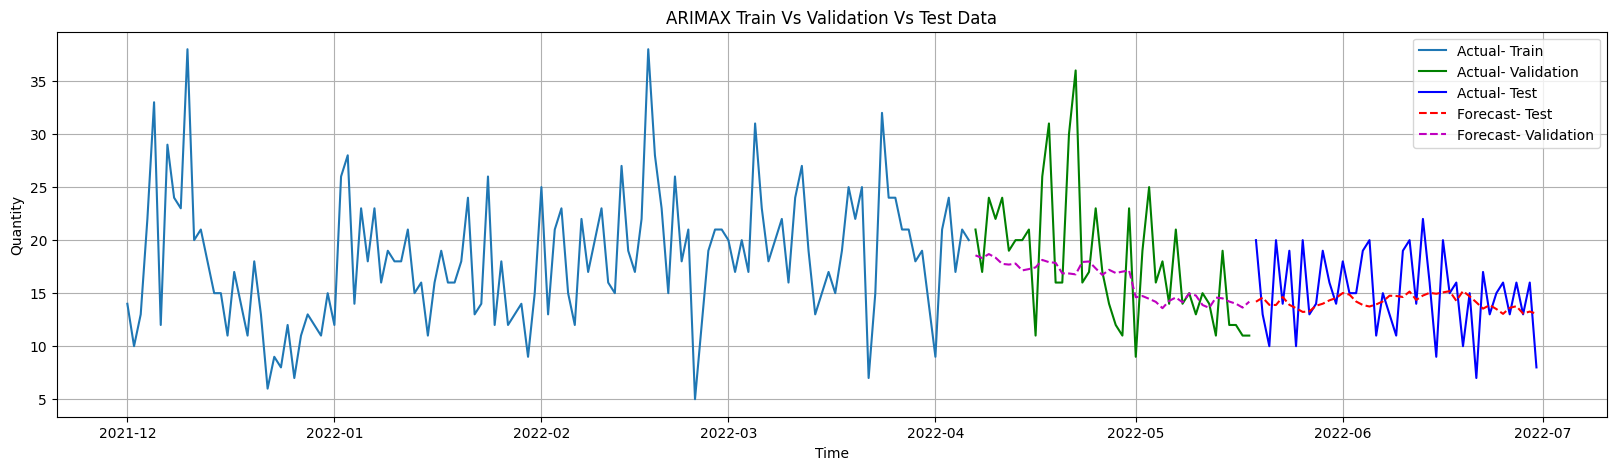

Validation Data:
MAE: 4.1745, RMSE: 5.707, MAPE: 22.2005%, R-Square: 0.0795, Adjusted R-Square: -0.0484
Test Data:
MAE: 2.9856, RMSE: 3.7415, MAPE: 21.3713%, R-Square: -0.0642, Adjusted R-Square: -0.208


In [ ]:
ARIMAX = ARIMAX_Model(1, 0, 1,product_clicks_impression_update, 'Quantity', ['Impressions', 'Season_Winter', 'Month_February', 'Month_March', 'Month_April'], 0.60, 0.20)

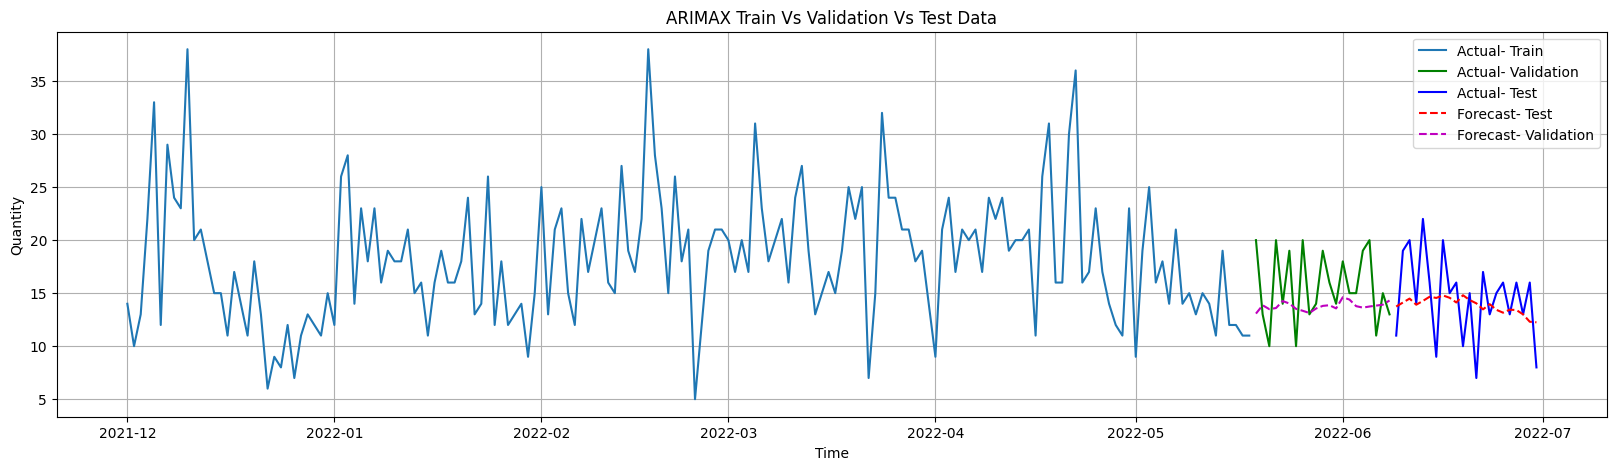

Validation Data:
MAE: 3.0236, RMSE: 3.8275, MAPE: 18.3913%, R-Square: -0.332, Adjusted R-Square: -0.665
Test Data:
MAE: 3.0794, RMSE: 3.8175, MAPE: 24.0842%, R-Square: 0.0084, Adjusted R-Square: -0.225


In [ ]:
ARIMAX = ARIMAX_Model(1, 0, 1,product_clicks_impression_update, 'Quantity', ['Clicks', 'Impressions', 'Season_Winter', 'Month_February'], 0.80, 0.10)

#### Seasonal Autoregressive Integrated Moving Average with Explanatory Variable (SARIMAX) model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

def SARIMAX_Model(Dataframe, p, d, q, ratioTest, ratioValidate, attributeQ, exog_cols, SOp, SOd, SOq, SOseason):
    product_clicks_impression_temp = Dataframe.copy()
    product_clicks_impression_temp = product_clicks_impression_temp.set_index('Day Index')

    train_size = int(ratioTest * len(product_clicks_impression_temp))
    validation_size = int(ratioValidate * len(product_clicks_impression_temp))

    df_train = product_clicks_impression_temp.iloc[:train_size][attributeQ]
    df_valid = product_clicks_impression_temp.iloc[train_size:train_size + validation_size][attributeQ]
    df_test = product_clicks_impression_temp.iloc[train_size + validation_size:][attributeQ]

    order = (p, d, q)
    seasonal_order = (SOp, SOd, SOq, SOseason)
    exog_data = product_clicks_impression_temp.iloc[:train_size][exog_cols]
    exog_data_valid = product_clicks_impression_temp.iloc[train_size:train_size + validation_size][exog_cols]
    exog_data_test = product_clicks_impression_temp.iloc[train_size + validation_size:][exog_cols]

    model = SARIMAX(df_train, order=order, exog=exog_data, seasonal_order=seasonal_order)
    model_fit = model.fit()

    forecast_valid = model_fit.get_forecast(steps=len(df_valid), exog=exog_data_valid)
    forecast_values_valid = forecast_valid.predicted_mean
    forecast_test = model_fit.get_forecast(steps=len(df_test), exog=exog_data_test)
    forecast_values_test = forecast_test.predicted_mean

    plt.figure(figsize=(20, 5))
    date1 = product_clicks_impression_temp.iloc[:train_size].index
    date2 = product_clicks_impression_temp.iloc[train_size:train_size + validation_size].index
    date3 = product_clicks_impression_temp.iloc[train_size + validation_size:].index
    # Actual values plotting
    plt.plot(date1, df_train.values, label='Actual- Train')
    plt.plot(date2, df_valid.values, label='Actual- Validation', color='green')
    plt.plot(date3, df_test.values, label='Actual- Test', color='blue')

    # Forecast Plot
    plt.plot(df_valid.index, forecast_values_valid, label='Forecast- Validation', color='red', linestyle='--')
    plt.plot(df_test.index, forecast_values_test, label='Forecast- Test', color='m', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate performance metrics for validation data
    valid_mae = mean_absolute_error(df_valid, forecast_values_valid)
    valid_rmse = np.sqrt(mean_squared_error(df_valid, forecast_values_valid))
    valid_mape = mean_absolute_percentage_error(df_valid, forecast_values_valid)
    valid_r_2 = r2_score(df_valid, forecast_values_valid)
    n_valid = len(df_valid)
    par = len(exog_cols)
    valid_adjusted_r_2 = 1 - (1 - valid_r_2) * (n_valid - 1) / (n_valid - par - 1)

    # Calculate performance metrics for test data
    test_mae = mean_absolute_error(df_test, forecast_values_test)
    test_rmse = np.sqrt(mean_squared_error(df_test, forecast_values_test))
    test_mape = mean_absolute_percentage_error(df_test, forecast_values_test)
    test_r_2 = r2_score(df_test, forecast_values_test)
    n_test = len(df_test)
    test_adjusted_r_2 = 1 - (1 - test_r_2) * (n_test - 1) / (n_test - par - 1)

    # Print the results using built-in round function
    print('Validation Data: ')
    print(f'MAE  : {round(valid_mae, 4)}, RMSE  : {round(valid_rmse, 4)}, MAPE  : {round(valid_mape * 100, 4)}%, R-square  : {round(valid_r_2, 4)}, Adjusted R-square  : {round(valid_adjusted_r_2, 4)}')
    print('Test Data: ')
    print(f'MAE  : {round(test_mae, 4)}, RMSE  : {round(test_rmse, 4)}, MAPE  : {round(test_mape * 100, 4)}%, R-square  : {round(test_r_2, 4)}, Adjusted R-square  : {round(test_adjusted_r_2, 4)}')

    return model_fit




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

def SARIMAX_Model(Dataframe, p, d, q, ratioTest, ratioValidate, attributeQ, exog_cols, SOp, SOd, SOq, SOseason):
    product_clicks_impression_temp = Dataframe.copy()
    product_clicks_impression_temp = product_clicks_impression_temp.set_index('Day Index')

    train_size = int(ratioTest * len(product_clicks_impression_temp))
    validation_size = int(ratioValidate * len(product_clicks_impression_temp))

    df_train = product_clicks_impression_temp.iloc[:train_size][attributeQ]
    df_valid = product_clicks_impression_temp.iloc[train_size:train_size + validation_size][attributeQ]
    df_test = product_clicks_impression_temp.iloc[train_size + validation_size:][attributeQ]

    order = (p, d, q)
    seasonal_order = (SOp, SOd, SOq, SOseason)
    exog_data = product_clicks_impression_temp.iloc[:train_size][exog_cols]
    exog_data_valid = product_clicks_impression_temp.iloc[train_size:train_size + validation_size][exog_cols]
    exog_data_test = product_clicks_impression_temp.iloc[train_size + validation_size:][exog_cols]

    # Create the SARIMAX model
    sarimax_model = SARIMAX(df_train, order=order, exog=exog_data, seasonal_order=seasonal_order)
    model_fit = sarimax_model.fit()  # Fit the model

    forecast_valid = model_fit.get_forecast(steps=len(df_valid), exog=exog_data_valid)
    forecast_values_valid = forecast_valid.predicted_mean
    forecast_test = model_fit.get_forecast(steps=len(df_test), exog=exog_data_test)
    forecast_values_test = forecast_test.predicted_mean

    plt.figure(figsize=(20, 5))
    date1 = product_clicks_impression_temp.iloc[:train_size].index
    date2 = product_clicks_impression_temp.iloc[train_size:train_size + validation_size].index
    date3 = product_clicks_impression_temp.iloc[train_size + validation_size:].index
    # Actual values plotting
    plt.plot(date1, df_train.values, label='Actual- Train')
    plt.plot(date2, df_valid.values, label='Actual- Validation', color='green')
    plt.plot(date3, df_test.values, label='Actual- Test', color='blue')

    # Forecast Plot
    plt.plot(df_valid.index, forecast_values_valid, label='Forecast- Validation', color='red', linestyle='--')
    plt.plot(df_test.index, forecast_values_test, label='Forecast- Test', color='m', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate performance metrics for validation data
    valid_mae = mean_absolute_error(df_valid, forecast_values_valid)
    valid_rmse = np.sqrt(mean_squared_error(df_valid, forecast_values_valid))
    valid_mape = mean_absolute_percentage_error(df_valid, forecast_values_valid)
    valid_r_2 = r2_score(df_valid, forecast_values_valid)
    n_valid = len(df_valid)
    par = len(exog_cols)
    valid_adjusted_r_2 = 1 - (1 - valid_r_2) * (n_valid - 1) / (n_valid - par - 1)

    # Calculate performance metrics for test data
    test_mae = mean_absolute_error(df_test, forecast_values_test)
    test_rmse = np.sqrt(mean_squared_error(df_test, forecast_values_test))
    test_mape = mean_absolute_percentage_error(df_test, forecast_values_test)
    test_r_2 = r2_score(df_test, forecast_values_test)
    n_test = len(df_test)
    test_adjusted_r_2 = 1 - (1 - test_r_2) * (n_test - 1) / (n_test - par - 1)

    # Print the results using built-in round function
    print('Validation Data: ')
    print(f'MAE  : {round(valid_mae, 4)}, RMSE  : {round(valid_rmse, 4)}, MAPE  : {round(valid_mape * 100, 4)}%, R-square  : {round(valid_r_2, 4)}, Adjusted R-square  : {round(valid_adjusted_r_2, 4)}')
    print('Test Data: ')
    print(f'MAE  : {round(test_mae, 4)}, RMSE  : {round(test_rmse, 4)}, MAPE  : {round(test_mape * 100, 4)}%, R-square  : {round(test_r_2, 4)}, Adjusted R-square  : {round(test_adjusted_r_2, 4)}')

    return model_fit

# Example usage with a different variable name
#SARIMAX = SARIMAX_Model(product_clicks_impression_update, 1, 0, 1, 0.60, 0.20, 'Quantity',['Impressions', 'Month_February', 'Month_March'], 0, 0, 0, 12)
#SARIMAX = SARIMAX_Model(product_clicks_impression_update, 1, 0, 1, 0.80, 0.10, 'Quantity',['Month_March', 'Month_December', 'Month_May'], 0, 0, 0, 12)

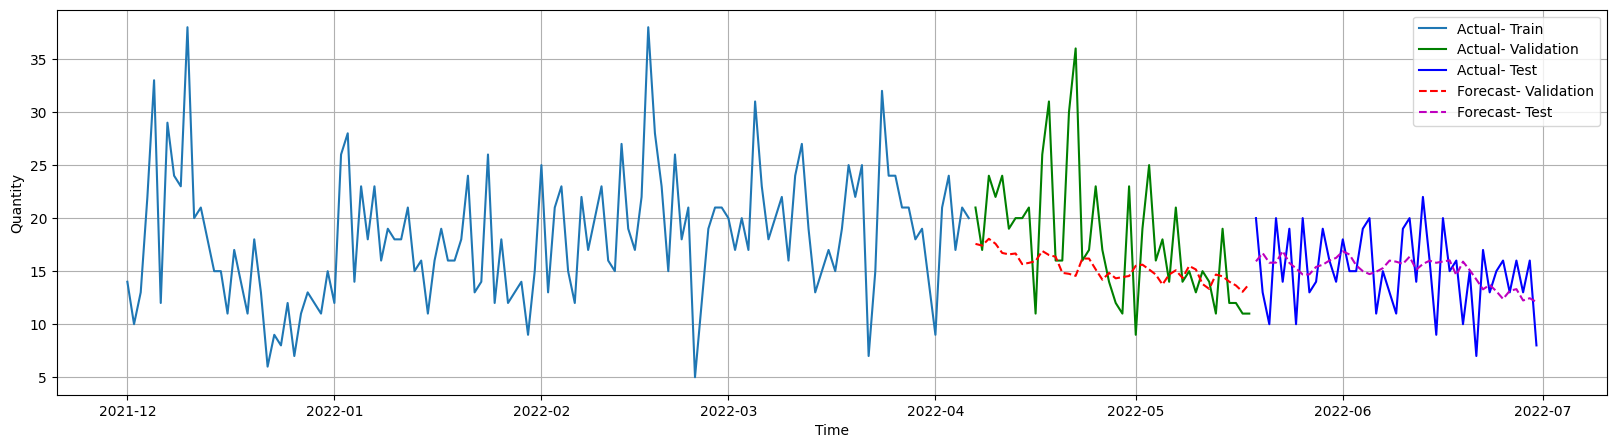

Validation Data: 
MAE  : 4.3746, RMSE  : 6.2077, MAPE  : 22.0956%, R-square  : -0.0892, Adjusted R-square  : -0.1752
Test Data: 
MAE  : 3.0229, RMSE  : 3.6107, MAPE  : 22.822%, R-square  : 0.0089, Adjusted R-square  : -0.0673


In [ ]:
model_fit1 = SARIMAX_Model(product_clicks_impression_update, 1, 0, 1, 0.60, 0.20, 'Quantity', ['Impressions', 'Month_February', 'Month_March'], 0, 0, 0, 12)


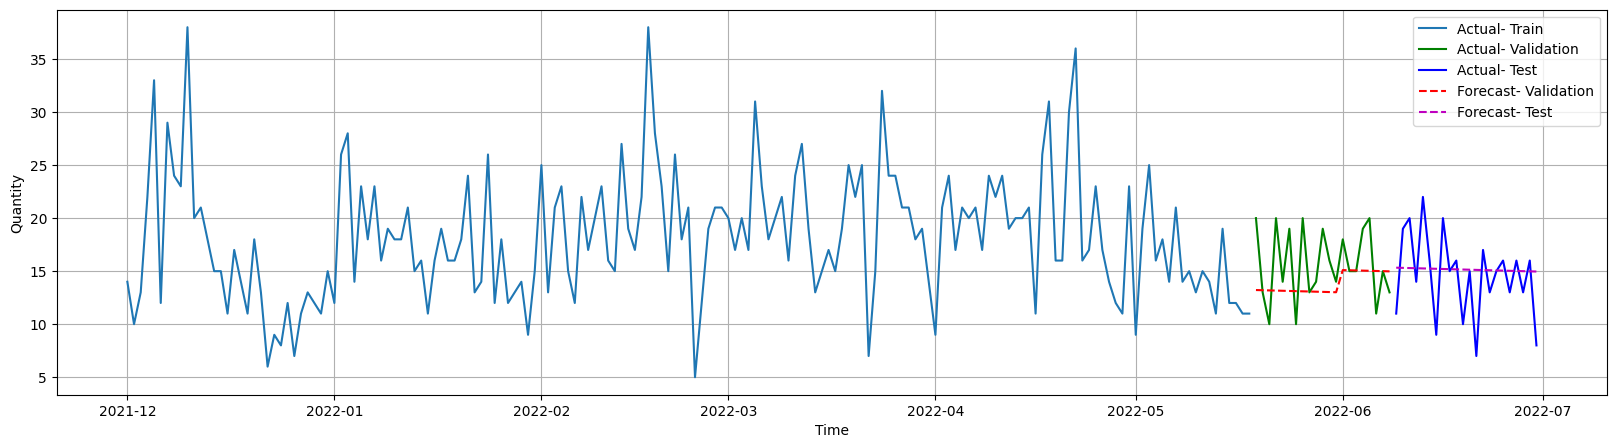

Validation Data: 
MAE  : 2.9823, RMSE  : 3.8431, MAPE  : 18.231%, R-square  : -0.343, Adjusted R-square  : -0.58
Test Data: 
MAE  : 2.9521, RMSE  : 3.8413, MAPE  : 25.4087%, R-square  : -0.004, Adjusted R-square  : -0.1714


In [ ]:
model_fit2 = SARIMAX_Model(product_clicks_impression_update, 1, 0, 1, 0.80, 0.10, 'Quantity', ['Month_March', 'Month_December', 'Month_May'], 0, 0, 0, 12)


#### Multiple Linear Regression (MLR) Model

In [ ]:
def MLR_Model(Dataframe, target, trainRatio, validationRatio, colList):
    product_clicks_impression_temp = Dataframe.copy()
    product_clicks_impression_temp = Dataframe.set_index('Day Index')
    train_size = int(trainRatio * len(product_clicks_impression_temp))
    validation_size = int(validationRatio * len(product_clicks_impression_temp))

    X_train_data = product_clicks_impression_temp.iloc[:train_size][colList]
    Y_train_data = product_clicks_impression_temp.iloc[:train_size][target]
    X_validation_data = product_clicks_impression_temp.iloc[train_size:train_size+validation_size][colList]
    Y_validation_data = product_clicks_impression_temp.iloc[train_size:train_size+validation_size][target]
    X_test_data = product_clicks_impression_temp.iloc[train_size+validation_size:][colList]
    Y_test_data = product_clicks_impression_temp.iloc[train_size+validation_size:][target]

    # Train the model
    model = LinearRegression()
    model.fit(X_train_data, Y_train_data)

    valid_predict = model.predict(X_validation_data)
    test_predict = model.predict(X_test_data)

    plt.figure(figsize=(20, 5))
    date1 = product_clicks_impression_temp.iloc[:train_size].index
    date2 = product_clicks_impression_temp.iloc[train_size:train_size+validation_size].index
    date3 = product_clicks_impression_temp.iloc[train_size+validation_size:].index

    # Actual values plotting
    plt.plot(date1, Y_train_data.values, label='Actual- Train')
    plt.plot(date2, Y_validation_data.values, label='Actual- Validation', color='green')
    plt.plot(date3, Y_test_data.values, label='Actual- Test', color='blue')

    # Forecaste Plot
    plt.plot(Y_test_data.index, test_predict, label='Forecast- Test', color='m', linestyle='--')
    plt.plot(Y_validation_data.index, valid_predict, label='Forecast- Validation', color='red', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()
    valid_mae = mean_absolute_error(Y_validation_data, valid_predict)
    valid_rmse = np.sqrt(mean_squared_error(Y_validation_data, valid_predict))
    valid_mape = mean_absolute_percentage_error(Y_validation_data, valid_predict)
    valid_r_2 = r2_score(Y_validation_data, valid_predict)
    n_valid = len(Y_validation_data)
    p = len(colList)
    valid_adjusted_r_2 = 1 - (1 - valid_r_2) * (n_valid - 1) / (n_valid - p - 1)

    test_mae = mean_absolute_error(Y_test_data, test_predict)
    test_rmse = np.sqrt(mean_squared_error(Y_test_data, test_predict))
    test_mape = mean_absolute_percentage_error(Y_test_data, test_predict)
    test_r_2 = r2_score(Y_test_data, test_predict)
    n_test = len(Y_test_data)

    test_adjusted_r_2 = 1 - (1 - test_r_2) * (n_test - 1) / (n_test - p - 1)
    # Corrected print statements
    print('Validation Data: ')
    print(f'MAE  : {round(valid_mae, 4)}, RMSE  : {round(valid_rmse, 4)}, MAPE  : {round(valid_mape * 100, 4)}%, R-square  : {round(valid_r_2, 4)}, Adjusted R-square  : {round(valid_adjusted_r_2, 4)}')
    print('Test Data: ')
    print(f'MAE  : {round(test_mae, 4)}, RMSE  : {round(test_rmse, 4)}, MAPE  : {round(test_mape * 100, 4)}%, R-square  : {round(test_r_2, 4)}, Adjusted R-square  : {round(test_adjusted_r_2, 4)}')


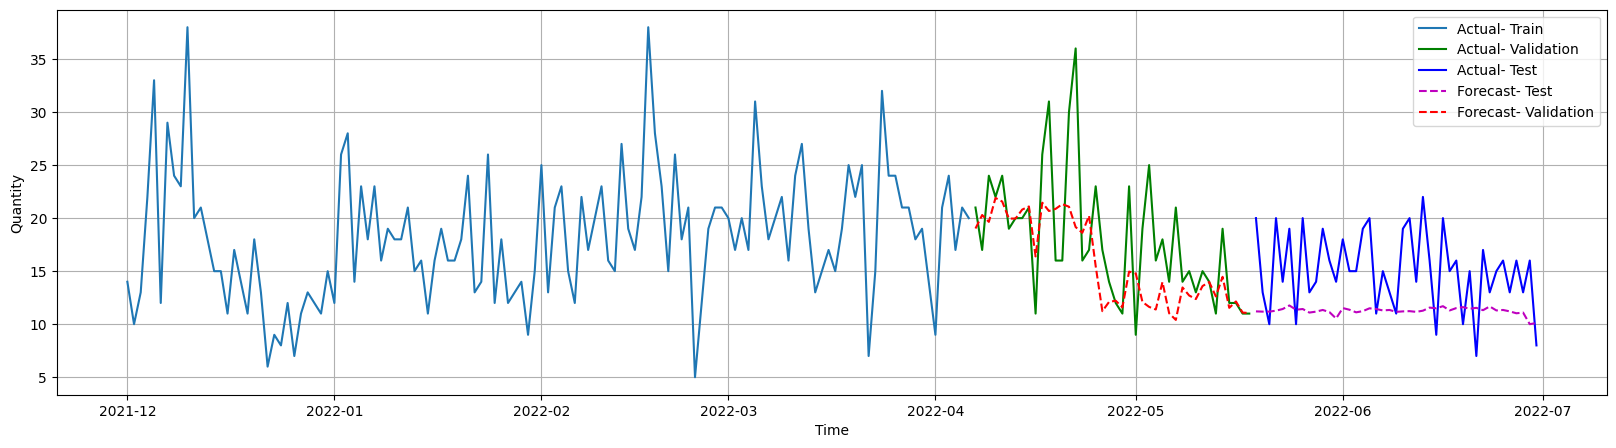

Validation Data: 
MAE  : 3.8147, RMSE  : 5.4304, MAPE  : 19.5306%, R-square  : 0.1665, Adjusted R-square  : 0.1007
Test Data: 
MAE  : 4.4784, RMSE  : 5.2483, MAPE  : 27.8572%, R-square  : -1.094, Adjusted R-square  : -1.2551


In [ ]:
MLR = MLR_Model(product_clicks_impression_update, 'Quantity', 0.60, 0.20, ['Clicks', 'Season_Winter', 'Month_December'])

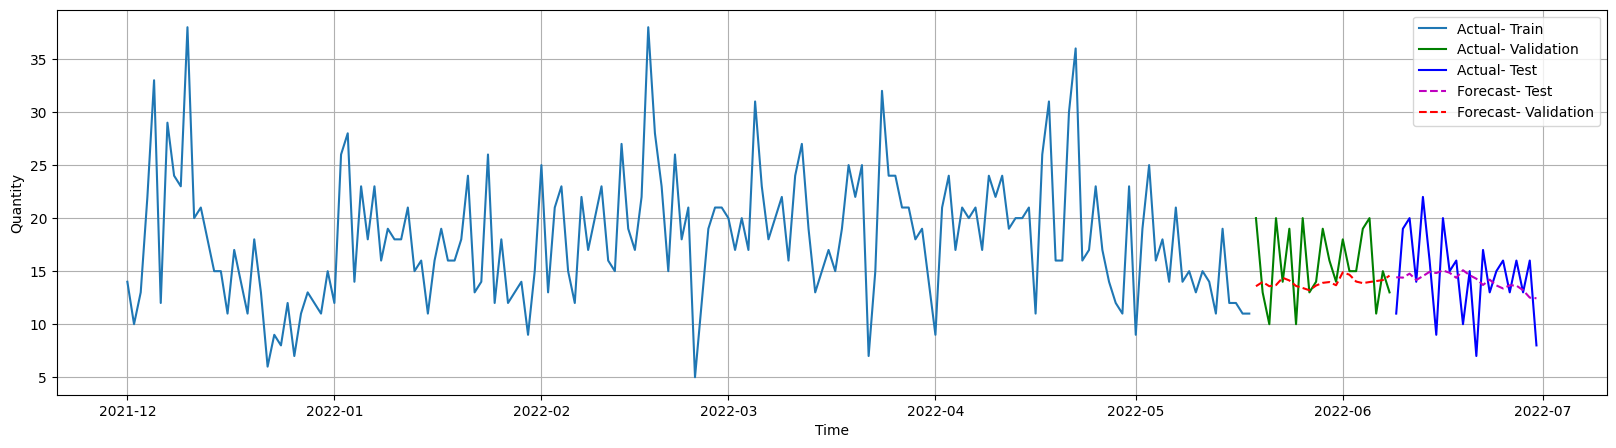

Validation Data: 
MAE  : 2.9428, RMSE  : 3.7253, MAPE  : 18.0461%, R-square  : -0.2619, Adjusted R-square  : -0.8027
Test Data: 
MAE  : 3.0413, RMSE  : 3.7927, MAPE  : 24.2897%, R-square  : 0.0212, Adjusted R-square  : -0.3703


In [ ]:
MLR = MLR_Model(product_clicks_impression_update, 'Quantity', 0.80, 0.10, ['Clicks', 'Impressions', 'Season_Winter', 'Month_February', 'Month_March', 'Month_May'])

In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Rename columns for Prophet
data_prophet = product_clicks_impression_update.rename(columns={'Day Index': 'ds', 'Quantity': 'y'})

# Initialize Prophet model
prophet_model = Prophet()
prophet_model.fit(data_prophet[['ds', 'y']])

# Make a forecast
future = prophet_model.make_future_dataframe(periods=30)  # Forecast 30 days into the future
forecast = prophet_model.predict(future)

# Calculate metrics for Prophet
y_true = data_prophet['y'][-30:].values  # Use last 30 days for evaluation
y_pred_prophet = forecast['yhat'][-30:].values  # Forecasted values for last 30 days

# Calculate evaluation metrics
mae_prophet = mean_absolute_error(y_true, y_pred_prophet)
mse_prophet = mean_squared_error(y_true, y_pred_prophet)
rmse_prophet = np.sqrt(mse_prophet)

print(f"Prophet MAE: {mae_prophet}")
print(f"Prophet MSE: {mse_prophet}")
print(f"Prophet RMSE: {rmse_prophet}")


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp32dcd1ox/set0uwfs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp32dcd1ox/mbfrhfyu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77727', 'data', 'file=/tmp/tmp32dcd1ox/set0uwfs.json', 'init=/tmp/tmp32dcd1ox/mbfrhfyu.json', 'output', 'file=/tmp/tmp32dcd1ox/prophet_modelau8phebk/prophet_model-20241119130047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:00:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:00:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet MAE: 2.7013676727728866
Prophet MSE: 12.761972698208256
Prophet RMSE: 3.5723903339652368


In [ ]:
from sklearn.metrics import r2_score

# Calculate MAPE for Prophet
mape_prophet = np.mean(np.abs((y_true - y_pred_prophet) / y_true)) * 100

# Calculate R² for Prophet
r2_prophet = r2_score(y_true, y_pred_prophet)

print(f"Prophet MAPE: {mape_prophet:.2f}%")
print(f"Prophet R²: {r2_prophet:.4f}")


Prophet MAPE: 22.13%
Prophet R²: 0.0349


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prepare the features (X) and target (y)
X = product_clicks_impression_update.drop(['Quantity', 'Day Index'], axis=1)  # Drop target and date columns
y = product_clicks_impression_update['Quantity']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Calculate evaluation metrics
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

print(f"XGBoost MAE: {mae_xgb}")
print(f"XGBoost MSE: {mse_xgb}")
print(f"XGBoost RMSE: {rmse_xgb}")


XGBoost MAE: 0.18417845215908316
XGBoost MSE: 0.32208437775725435
XGBoost RMSE: 0.5675247816238991


In [ ]:
# Calculate MAPE for XGBoost
mape_xgb = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100

# Calculate R² for XGBoost
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MAPE: {mape_xgb:.2f}%")
print(f"XGBoost R²: {r2_xgb:.4f}")


XGBoost MAPE: 1.65%
XGBoost R²: 0.9911


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Assuming 'product_clicks_impression_update' DataFrame already has necessary lagged features
# Add lagged target values as additional features for dynamic regression

# Define the number of lags to create
num_lags = 3

# Create lagged features for 'Quantity' to capture temporal dependencies
for lag in range(1, num_lags + 1):
    product_clicks_impression_update[f'Quantity_lag{lag}'] = product_clicks_impression_update['Quantity'].shift(lag)

# Drop rows with NaN values resulting from lagging
product_clicks_impression_update.dropna(inplace=True)

# Prepare the features (X) and target (y)
X = product_clicks_impression_update.drop(['Quantity', 'Day Index'], axis=1)  # Drop target and date columns
y = product_clicks_impression_update['Quantity']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Calculate evaluation metrics
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

print(f"XGBoost MAE: {mae_xgb}")
print(f"XGBoost MSE: {mse_xgb}")
print(f"XGBoost RMSE: {rmse_xgb}")


XGBoost MAE: 0.37192399161202566
XGBoost MSE: 1.5711488559293554
XGBoost RMSE: 1.2534547682024093


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Prepare the features (X) and target (y)
X = product_clicks_impression_update.drop(['Quantity', 'Day Index'], axis=1)  # Drop target and date columns
y = product_clicks_impression_update['Quantity']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Calculate evaluation metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print(f"Random Forest MAE: {mae_rf}")
print(f"Random Forest MSE: {mse_rf}")
print(f"Random Forest RMSE: {rmse_rf}")


Random Forest MAE: 0.4188095238095239
Random Forest MSE: 1.8300071428571432
Random Forest RMSE: 1.3527775659202599


In [ ]:
import numpy as np
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Prepare the features (X) and target (y)
X = product_clicks_impression_update.drop(['Quantity', 'Day Index'], axis=1)
y = product_clicks_impression_update['Quantity']

# Step 1: Fit a Time-Series Model (e.g., ARIMA) on the target variable to capture temporal dependencies
# Choose the order of the ARIMA model (p, d, q) based on your data analysis
arima_order = (1, 1, 1)  # Example order; adjust based on model diagnostics
arima_model = ARIMA(y, order=arima_order).fit()

# Generate ARIMA predictions (one-step ahead forecasts)
y_pred_arima = arima_model.predict(start=1, end=len(y), dynamic=False)
X['ARIMA_Predictions'] = y_pred_arima  # Add ARIMA predictions as a new feature

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Train the XGBoost Model with the ARIMA predictions as an additional feature
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Calculate evaluation metrics
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mape_xgb = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MAE: {mae_xgb}")
print(f"XGBoost MSE: {mse_xgb}")
print(f"XGBoost RMSE: {rmse_xgb}")
print(f"XGBoost MAPE: {mape_xgb:.2f}%")
print(f"XGBoost R²: {r2_xgb:.4f}")


XGBoost MAE: 0.37896272114345003
XGBoost MSE: 1.5497180193335789
XGBoost RMSE: 1.244876708487061
XGBoost MAPE: 4.06%
XGBoost R²: 0.9540


## REPORT:

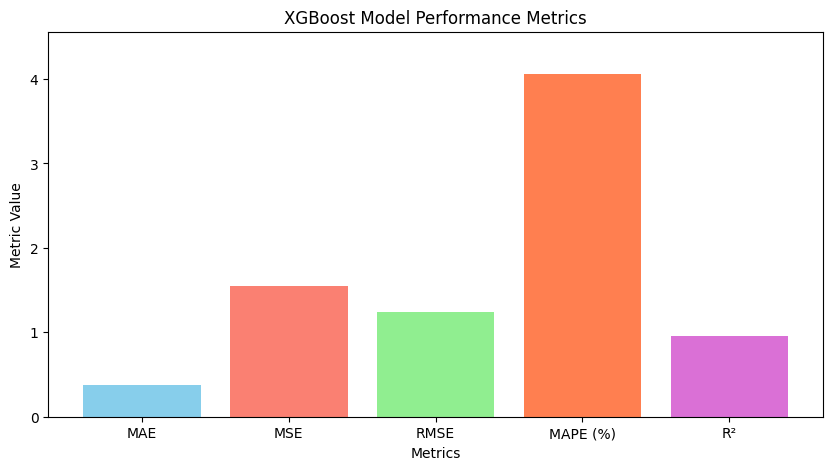

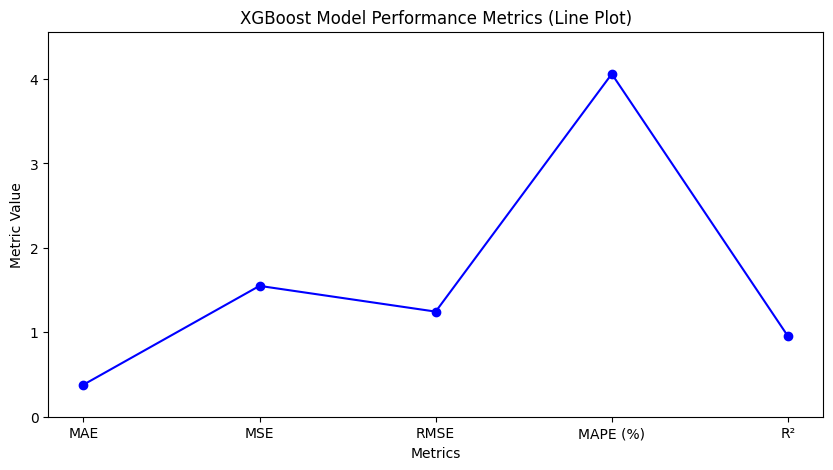

In [ ]:
import matplotlib.pyplot as plt

# XGBoost metrics
metrics = {
    'MAE': 0.37896272114345003,
    'MSE': 1.5497180193335789,
    'RMSE': 1.244876708487061,
    'MAPE (%)': 4.06,
    'R²': 0.9540
}

# Extract metric names and values
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

# Bar Plot
plt.figure(figsize=(10, 5))
plt.bar(metric_names, metric_values, color=['skyblue', 'salmon', 'lightgreen', 'coral', 'orchid'])
plt.title("XGBoost Model Performance Metrics")
plt.ylabel("Metric Value")
plt.xlabel("Metrics")
plt.ylim(0, max(metric_values) + 0.5)  # Adjust y-axis range for better visibility
plt.show()

# Line Plot
plt.figure(figsize=(10, 5))
plt.plot(metric_names, metric_values, marker='o', linestyle='-', color='b')
plt.title("XGBoost Model Performance Metrics (Line Plot)")
plt.ylabel("Metric Value")
plt.xlabel("Metrics")
plt.ylim(0, max(metric_values) + 0.5)  # Adjust y-axis range for better visibility
plt.show()


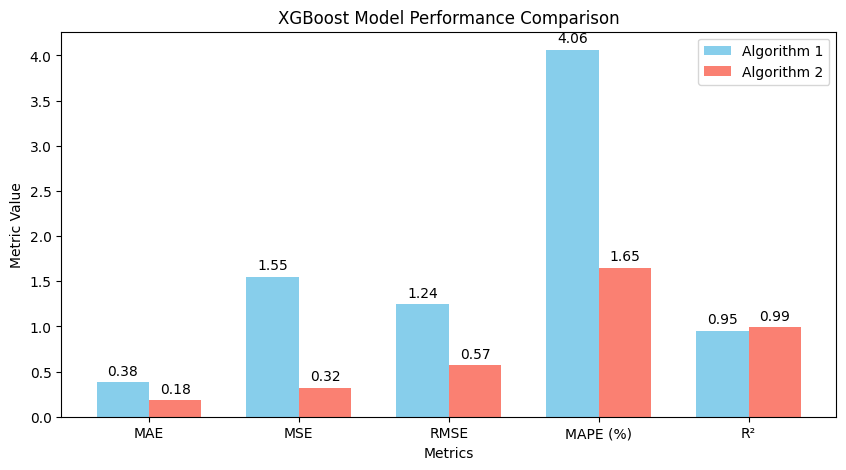

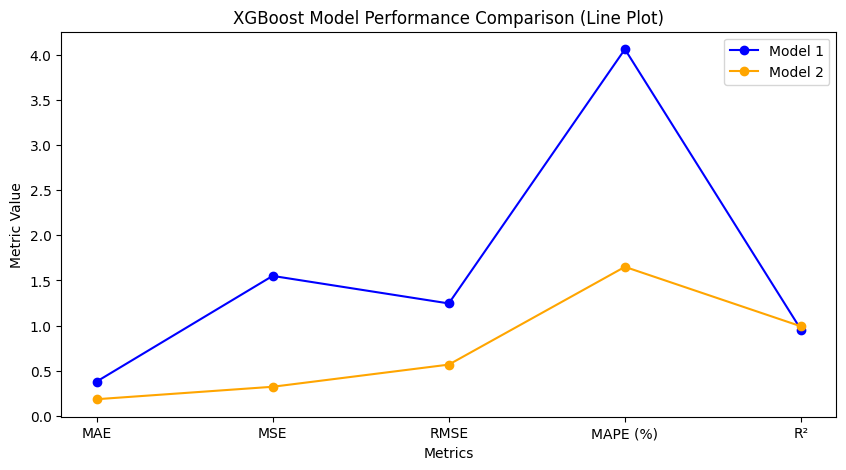

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# XGBoost metrics for two models
metrics_1 = {
    'MAE': 0.37896272114345003,
    'MSE': 1.5497180193335789,
    'RMSE': 1.244876708487061,
    'MAPE (%)': 4.06,
    'R²': 0.9540
}

metrics_2 = {
    'MAE': 0.18417845215908316,
    'MSE': 0.32208437775725435,
    'RMSE': 0.5675247816238991,
    'MAPE (%)': 1.65,
    'R²': 0.9911
}

# Metric names and values for both models
metric_names = list(metrics_1.keys())
metric_values_1 = list(metrics_1.values())
metric_values_2 = list(metrics_2.values())

# Bar Plot
x = np.arange(len(metric_names))  # the label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.bar(x - width/2, metric_values_1, width, label='Algorithm 1', color='skyblue')
bars2 = ax.bar(x + width/2, metric_values_2, width, label='Algorithm 2', color='salmon')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel("Metrics")
ax.set_ylabel("Metric Value")
ax.set_title("XGBoost Model Performance Comparison")
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.legend()

# Add value labels on the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',  # Format to 2 decimal places
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.show()

# Line Plot for both sets
plt.figure(figsize=(10, 5))
plt.plot(metric_names, metric_values_1, marker='o', linestyle='-', color='b', label='Model 1')
plt.plot(metric_names, metric_values_2, marker='o', linestyle='-', color='orange', label='Model 2')
plt.title("XGBoost Model Performance Comparison (Line Plot)")
plt.ylabel("Metric Value")
plt.xlabel("Metrics")
plt.legend()
plt.show()


![image.png](attachment:image.png)

In [ ]:
import pandas as pd
import numpy as np

# Assuming product_clicks_impression_update is your dataset

# Adding lag features (e.g., previous day's quantity)
product_clicks_impression_update['Quantity_lag1'] = product_clicks_impression_update['Quantity'].shift(1)
product_clicks_impression_update['Quantity_lag2'] = product_clicks_impression_update['Quantity'].shift(2)
product_clicks_impression_update['Quantity_lag3'] = product_clicks_impression_update['Quantity'].shift(3)

# Add more lag features if necessary

# Handle missing values (e.g., fill first few NaNs in lag columns)
product_clicks_impression_update.fillna(0, inplace=True)

# Prepare the features (X) and target (y)
X = product_clicks_impression_update.drop(['Quantity', 'Day Index'], axis=1)  # Drop target and date columns
y = product_clicks_impression_update['Quantity']


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Calculate evaluation metrics
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

print(f"XGBoost MAE: {mae_xgb}")
print(f"XGBoost MSE: {mse_xgb}")
print(f"XGBoost RMSE: {rmse_xgb}")


XGBoost MAE: 0.3720837093534924
XGBoost MSE: 1.5718311631227109
XGBoost RMSE: 1.2537269093078887


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA model to the residuals of the XGBoost model
residuals = y_test - y_pred_xgb

# Fit ARIMA model (tune p, d, q parameters as needed)
arima_model = ARIMA(residuals, order=(1, 1, 1))  # Example (p, d, q)
arima_model_fit = arima_model.fit()

# Make predictions from ARIMA (residuals adjustment)
arima_residuals_pred = arima_model_fit.forecast(len(residuals))

# Add the ARIMA-adjusted residuals to XGBoost predictions
y_pred_combined = y_pred_xgb + arima_residuals_pred

# Recalculate evaluation metrics with the combined predictions
mae_combined = mean_absolute_error(y_test, y_pred_combined)
mse_combined = mean_squared_error(y_test, y_pred_combined)
rmse_combined = np.sqrt(mse_combined)

print(f"Combined Model MAE: {mae_combined}")
print(f"Combined Model MSE: {mse_combined}")
print(f"Combined Model RMSE: {rmse_combined}")


Combined Model MAE: 0.4252342562447636
Combined Model MSE: 1.5671607800099092
Combined Model RMSE: 1.251862923809915


In [ ]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Prepare the features (X) and target (y)
X = product_clicks_impression_update.drop(['Quantity', 'Day Index'], axis=1)  # Drop target and date columns
y = product_clicks_impression_update['Quantity']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Combine predictions by averaging
y_pred_ensemble = (y_pred_xgb + y_pred_rf) / 2

# Calculate evaluation metrics for the ensemble model
mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble)
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
rmse_ensemble = np.sqrt(mse_ensemble)
mape_ensemble = np.mean(np.abs((y_test - y_pred_ensemble) / y_test)) * 100
r2_ensemble = r2_score(y_test, y_pred_ensemble)

print(f"Ensemble MAE: {mae_ensemble}")
print(f"Ensemble MSE: {mse_ensemble}")
print(f"Ensemble RMSE: {rmse_ensemble}")
print(f"Ensemble MAPE: {mape_ensemble:.2f}%")
print(f"Ensemble R²: {r2_ensemble:.4f}")


Ensemble MAE: 0.39381115504673553
Ensemble MSE: 1.6974791679218133
Ensemble RMSE: 1.302873427437145
Ensemble MAPE: 4.14%
Ensemble R²: 0.9496


In [ ]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Prepare the features (X) and target (y)
X = product_clicks_impression_update.drop(['Quantity', 'Day Index'], axis=1)  # Drop target and date columns
y = product_clicks_impression_update['Quantity']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Initialize and train the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Combine predictions by averaging
y_pred_ensemble = (y_pred_lr + y_pred_xgb) / 2

# Calculate evaluation metrics for the ensemble model
mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble)
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
rmse_ensemble = np.sqrt(mse_ensemble)
mape_ensemble = np.mean(np.abs((y_test - y_pred_ensemble) / y_test)) * 100
r2_ensemble = r2_score(y_test, y_pred_ensemble)

print(f"Ensemble MAE: {mae_ensemble}")
print(f"Ensemble MSE: {mse_ensemble}")
print(f"Ensemble RMSE: {rmse_ensemble}")
print(f"Ensemble MAPE: {mape_ensemble:.2f}%")
print(f"Ensemble R²: {r2_ensemble:.4f}")


Ensemble MAE: 0.48685909866679616
Ensemble MSE: 1.3886830539316706
Ensemble RMSE: 1.178423970365365
Ensemble MAPE: 4.78%
Ensemble R²: 0.9588


![image.png](attachment:image.png)

In [ ]:
# Calculate evaluation metrics for the ensemble model
mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble)
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
rmse_ensemble = np.sqrt(mse_ensemble)
mape_ensemble = np.mean(np.abs((y_test - y_pred_ensemble) / y_test)) * 100
r2_ensemble = r2_score(y_test, y_pred_ensemble)

# Calculate "accuracy-like" metric
accuracy_ensemble = (1 - (mape_ensemble / 100)) * 100

# Display metrics
print(f"Ensemble MAE: {mae_ensemble}")
print(f"Ensemble MSE: {mse_ensemble}")
print(f"Ensemble RMSE: {rmse_ensemble}")
print(f"Ensemble MAPE: {mape_ensemble:.2f}%")
print(f"Ensemble R²: {r2_ensemble:.4f}")
print(f"Ensemble Accuracy-like Metric: {accuracy_ensemble:.2f}%")


Ensemble MAE: 0.48685909866679616
Ensemble MSE: 1.3886830539316706
Ensemble RMSE: 1.178423970365365
Ensemble MAPE: 4.78%
Ensemble R²: 0.9588
Ensemble Accuracy-like Metric: 95.22%


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Prepare the features (X) and target (y)
X = product_clicks_impression_update.drop(['Quantity', 'Day Index'], axis=1)  # Drop target and date columns
y = product_clicks_impression_update['Quantity']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Calculate evaluation metrics
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mape_xgb = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100
r2_xgb = r2_score(y_test, y_pred_xgb)

# Calculate accuracy-like metric
accuracy_xgb = 100 - mape_xgb

# Print all metrics
print(f"XGBoost MAE: {mae_xgb}")
print(f"XGBoost MSE: {mse_xgb}")
print(f"XGBoost RMSE: {rmse_xgb}")
print(f"XGBoost MAPE: {mape_xgb:.2f}%")
print(f"XGBoost R²: {r2_xgb:.4f}")
print(f"XGBoost Accuracy (based on MAPE): {accuracy_xgb:.2f}%")


XGBoost MAE: 0.3720837093534924
XGBoost MSE: 1.5718311631227109
XGBoost RMSE: 1.2537269093078887
XGBoost MAPE: 4.05%
XGBoost R²: 0.9534
XGBoost Accuracy (based on MAPE): 95.95%


In [ ]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Prepare the features (X) and target (y)
X = product_clicks_impression_update.drop(['Quantity', 'Day Index'], axis=1)  # Drop target and date columns
y = product_clicks_impression_update['Quantity']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning for XGBoost
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0]
}
xgb_search = RandomizedSearchCV(xgb_model, xgb_params, n_iter=10, scoring='neg_mean_absolute_error', cv=5, random_state=42, n_jobs=-1)
xgb_search.fit(X_train_scaled, y_train)
best_xgb_model = xgb_search.best_estimator_

# Hyperparameter tuning for Linear Regression
lr_model = LinearRegression()
lr_params = {'fit_intercept': [True, False]}  # Removed 'normalize'
lr_search = GridSearchCV(lr_model, lr_params, scoring='neg_mean_absolute_error', cv=5)
lr_search.fit(X_train_scaled, y_train)
best_lr_model = lr_search.best_estimator_

# Predictions with optimized models
y_pred_xgb = best_xgb_model.predict(X_test_scaled)
y_pred_lr = best_lr_model.predict(X_test_scaled)

# Optimizing ensemble weights
def ensemble_predictions(w_xgb, w_lr):
    return (w_xgb * y_pred_xgb + w_lr * y_pred_lr) / (w_xgb + w_lr)

# Try different weight combinations
best_mae, best_weights = float("inf"), (0.5, 0.5)
for w_xgb in np.arange(0, 1.1, 0.1):
    w_lr = 1 - w_xgb
    y_pred_ensemble = ensemble_predictions(w_xgb, w_lr)
    mae = mean_absolute_error(y_test, y_pred_ensemble)
    if mae < best_mae:
        best_mae, best_weights = mae, (w_xgb, w_lr)

# Final ensemble predictions with optimized weights
w_xgb, w_lr = best_weights
y_pred_ensemble_final = ensemble_predictions(w_xgb, w_lr)

# Calculate evaluation metrics for the final ensemble model
mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble_final)
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble_final)
rmse_ensemble = np.sqrt(mse_ensemble)
mape_ensemble = np.mean(np.abs((y_test - y_pred_ensemble_final) / y_test)) * 100
r2_ensemble = r2_score(y_test, y_pred_ensemble_final)

print("Optimized Ensemble Model Metrics:")
print(f"Best Weights -> XGBoost: {w_xgb}, Linear Regression: {w_lr}")
print(f"Ensemble MAE: {mae_ensemble}")
print(f"Ensemble MSE: {mse_ensemble}")
print(f"Ensemble RMSE: {rmse_ensemble}")
print(f"Ensemble MAPE: {mape_ensemble:.2f}%")
print(f"Ensemble R²: {r2_ensemble:.4f}")


Optimized Ensemble Model Metrics:
Best Weights -> XGBoost: 1.0, Linear Regression: 0.0
Ensemble MAE: 0.37523408163161504
Ensemble MSE: 1.7293170551018062
Ensemble RMSE: 1.3150350014740315
Ensemble MAPE: 4.13%
Ensemble R²: 0.9487


In [ ]:
# Calculate accuracy as 1 - MAPE for the ensemble model
accuracy_ensemble = 100 - mape_ensemble

# Print out the accuracy alongside other metrics
print("Optimized Ensemble Model Metrics:")
print(f"Best Weights -> XGBoost: {w_xgb}, Linear Regression: {w_lr}")
print(f"Ensemble MAE: {mae_ensemble}")
print(f"Ensemble MSE: {mse_ensemble}")
print(f"Ensemble RMSE: {rmse_ensemble}")
print(f"Ensemble MAPE: {mape_ensemble:.2f}%")
print(f"Ensemble R²: {r2_ensemble:.4f}")
print(f"Ensemble Accuracy: {accuracy_ensemble:.2f}%")


Optimized Ensemble Model Metrics:
Best Weights -> XGBoost: 1.0, Linear Regression: 0.0
Ensemble MAE: 0.37523408163161504
Ensemble MSE: 1.7293170551018062
Ensemble RMSE: 1.3150350014740315
Ensemble MAPE: 4.13%
Ensemble R²: 0.9487
Ensemble Accuracy: 95.87%


In [ ]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Prepare the features (X) and target (y)
X = product_clicks_impression_update.drop(['Quantity', 'Day Index'], axis=1)  # Drop target and date columns
y = product_clicks_impression_update['Quantity']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning for XGBoost
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0]
}
xgb_search = RandomizedSearchCV(xgb_model, xgb_params, n_iter=10, scoring='neg_mean_absolute_error', cv=5, random_state=42, n_jobs=-1)
xgb_search.fit(X_train, y_train)
best_xgb_model = xgb_search.best_estimator_

# Hyperparameter tuning for Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rf_search = RandomizedSearchCV(rf_model, rf_params, n_iter=10, scoring='neg_mean_absolute_error', cv=5, random_state=42, n_jobs=-1)
rf_search.fit(X_train, y_train)
best_rf_model = rf_search.best_estimator_

# Predictions with optimized models
y_pred_xgb = best_xgb_model.predict(X_test)
y_pred_rf = best_rf_model.predict(X_test)

# Optimizing ensemble weights
def ensemble_predictions(w_xgb, w_rf):
    return (w_xgb * y_pred_xgb + w_rf * y_pred_rf) / (w_xgb + w_rf)

# Try different weight combinations
best_mae, best_weights = float("inf"), (0.5, 0.5)
for w_xgb in np.arange(0, 1.1, 0.1):
    w_rf = 1 - w_xgb
    y_pred_ensemble = ensemble_predictions(w_xgb, w_rf)
    mae = mean_absolute_error(y_test, y_pred_ensemble)
    if mae < best_mae:
        best_mae, best_weights = mae, (w_xgb, w_rf)

# Final ensemble predictions with optimized weights
w_xgb, w_rf = best_weights
y_pred_ensemble_final = ensemble_predictions(w_xgb, w_rf)

# Calculate evaluation metrics for the final ensemble model
mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble_final)
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble_final)
rmse_ensemble = np.sqrt(mse_ensemble)
mape_ensemble = np.mean(np.abs((y_test - y_pred_ensemble_final) / y_test)) * 100
r2_ensemble = r2_score(y_test, y_pred_ensemble_final)
accuracy_ensemble = 100 - mape_ensemble

print("Optimized Ensemble Model Metrics:")
print(f"Best Weights -> XGBoost: {w_xgb}, Random Forest: {w_rf}")
print(f"Ensemble MAE: {mae_ensemble}")
print(f"Ensemble MSE: {mse_ensemble}")
print(f"Ensemble RMSE: {rmse_ensemble}")
print(f"Ensemble MAPE: {mape_ensemble:.2f}%")
print(f"Ensemble R²: {r2_ensemble:.4f}")
print(f"Ensemble Accuracy: {accuracy_ensemble:.2f}%")


Optimized Ensemble Model Metrics:
Best Weights -> XGBoost: 0.0, Random Forest: 1.0
Ensemble MAE: 0.3750000000000008
Ensemble MSE: 1.574900793650798
Ensemble RMSE: 1.254950514423098
Ensemble MAPE: 4.05%
Ensemble R²: 0.9533
Ensemble Accuracy: 95.95%


In [ ]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Prepare the features (X) and target (y)
X = product_clicks_impression_update.drop(['Quantity', 'Day Index'], axis=1)  # Drop target and date columns
y = product_clicks_impression_update['Quantity']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Calculate evaluation metrics for XGBoost
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mape_xgb = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MAE: {mae_xgb}")
print(f"XGBoost MSE: {mse_xgb}")
print(f"XGBoost RMSE: {rmse_xgb}")
print(f"XGBoost MAPE: {mape_xgb:.2f}%")
print(f"XGBoost R²: {r2_xgb:.4f}")

# Calculate residuals from XGBoost predictions
residuals = y_test - y_pred_xgb

# Fit an ARIMA model on the residuals (p, d, q can be optimized via grid search)
arima_model = ARIMA(residuals, order=(1, 1, 1))  # Example order, tune as needed
arima_model_fit = arima_model.fit()

# Forecast residuals using ARIMA
arima_residuals_pred = arima_model_fit.forecast(len(residuals))

# Combine XGBoost predictions with ARIMA residuals predictions
y_pred_combined = y_pred_xgb + arima_residuals_pred

# Calculate evaluation metrics for the combined model
mae_combined = mean_absolute_error(y_test, y_pred_combined)
mse_combined = mean_squared_error(y_test, y_pred_combined)
rmse_combined = np.sqrt(mse_combined)
mape_combined = np.mean(np.abs((y_test - y_pred_combined) / y_test)) * 100
r2_combined = r2_score(y_test, y_pred_combined)

print("\nCombined Model Metrics:")
print(f"Combined Model MAE: {mae_combined}")
print(f"Combined Model MSE: {mse_combined}")
print(f"Combined Model RMSE: {rmse_combined}")
print(f"Combined Model MAPE: {mape_combined:.2f}%")
print(f"Combined Model R²: {r2_combined:.4f}")


XGBoost MAE: 0.3720837093534924
XGBoost MSE: 1.5718311631227109
XGBoost RMSE: 1.2537269093078887
XGBoost MAPE: 4.05%
XGBoost R²: 0.9534

Combined Model Metrics:
Combined Model MAE: 0.4252342562447636
Combined Model MSE: 1.5671607800099092
Combined Model RMSE: 1.251862923809915
Combined Model MAPE: 19.09%
Combined Model R²: 0.9535


In [ ]:
# Calculate Mean Absolute Percentage Accuracy (MAPA)
accuracy_mapa = 100 - mape_combined  # Accuracy derived from MAPE

# Calculate Symmetric Mean Absolute Percentage Error (SMAPE)
smape_combined = 100 * np.mean(2 * np.abs(y_test - y_pred_combined) / (np.abs(y_test) + np.abs(y_pred_combined)))

print(f"\nCombined Model Mean Absolute Percentage Accuracy (MAPA): {accuracy_mapa:.2f}%")
print(f"Combined Model Symmetric Mean Absolute Percentage Error (SMAPE): {smape_combined:.2f}%")



Combined Model Mean Absolute Percentage Accuracy (MAPA): 80.91%
Combined Model Symmetric Mean Absolute Percentage Error (SMAPE): 21.85%


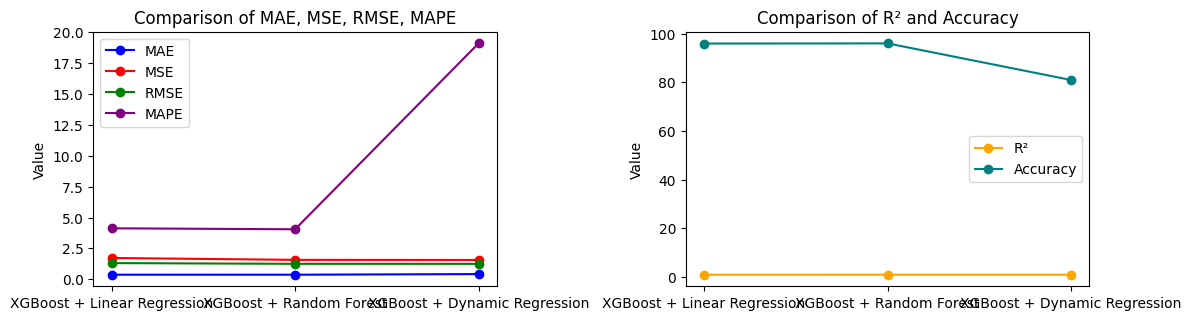

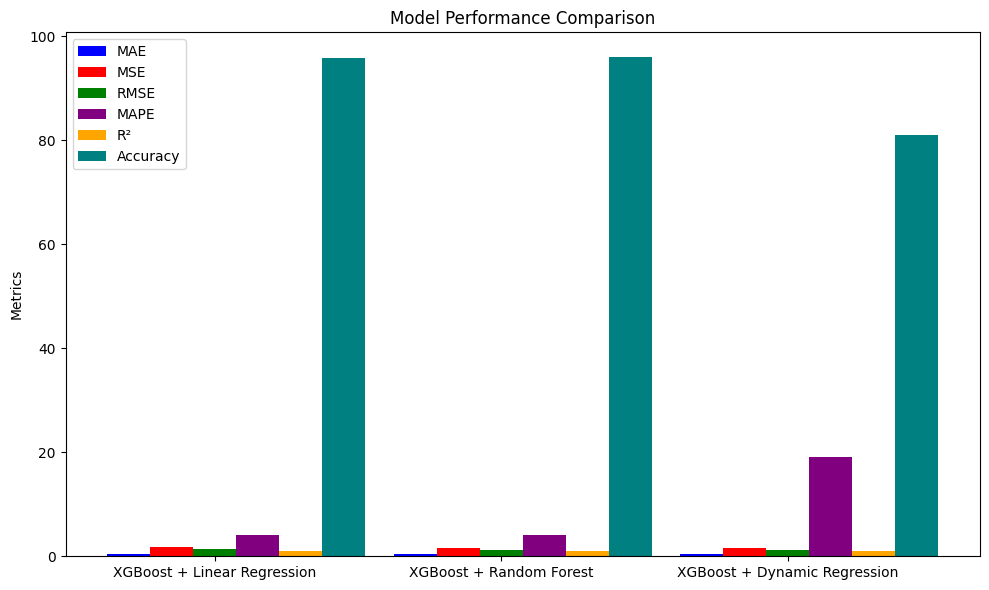

In [ ]:
import matplotlib.pyplot as plt

# Data for metrics
models = ['XGBoost + Linear Regression', 'XGBoost + Random Forest', 'XGBoost + Dynamic Regression']
mae = [0.37523408163161504, 0.3750000000000008, 0.4252342562447636]
mse = [1.7293170551018062, 1.574900793650798, 1.5671607800099092]
rmse = [1.3150350014740315, 1.254950514423098, 1.251862923809915]
mape = [4.13, 4.05, 19.09]
r2 = [0.9487, 0.9533, 0.9535]
accuracy = [95.87, 95.95, 80.91]

# Line graph for metrics (MAE, MSE, RMSE, MAPE, R², Accuracy)
plt.figure(figsize=(12, 6))

# Plot MAE, MSE, RMSE, and MAPE
plt.subplot(2, 2, 1)
plt.plot(models, mae, label='MAE', marker='o', color='blue')
plt.plot(models, mse, label='MSE', marker='o', color='red')
plt.plot(models, rmse, label='RMSE', marker='o', color='green')
plt.plot(models, mape, label='MAPE', marker='o', color='purple')
plt.title("Comparison of MAE, MSE, RMSE, MAPE")
plt.ylabel("Value")
plt.legend()

# Plot R² and Accuracy
plt.subplot(2, 2, 2)
plt.plot(models, r2, label='R²', marker='o', color='orange')
plt.plot(models, accuracy, label='Accuracy', marker='o', color='teal')
plt.title("Comparison of R² and Accuracy")
plt.ylabel("Value")
plt.legend()

plt.tight_layout()
plt.show()

# Bar graph for metrics
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.15  # Bar width
x = np.arange(len(models))

# Plotting the bars for each metric
ax.bar(x - 2*width, mae, width, label='MAE', color='blue')
ax.bar(x - width, mse, width, label='MSE', color='red')
ax.bar(x, rmse, width, label='RMSE', color='green')
ax.bar(x + width, mape, width, label='MAPE', color='purple')
ax.bar(x + 2*width, r2, width, label='R²', color='orange')
ax.bar(x + 3*width, accuracy, width, label='Accuracy', color='teal')

# Labels and title
ax.set_ylabel('Metrics')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Prepare the features (X) and target (y)
X = product_clicks_impression_update.drop(['Quantity', 'Day Index'], axis=1)  # Drop target and date columns
y = product_clicks_impression_update['Quantity']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# Initialize and train the Decision Tree model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions with both models
y_pred_xgb = xgb_model.predict(X_test)
y_pred_dt = dt_model.predict(X_test)

# Combine predictions by averaging
y_pred_combined = (y_pred_xgb + y_pred_dt) / 2

# Calculate evaluation metrics for the combined model
mae_combined = mean_absolute_error(y_test, y_pred_combined)
mse_combined = mean_squared_error(y_test, y_pred_combined)
rmse_combined = np.sqrt(mse_combined)
mape_combined = np.mean(np.abs((y_test - y_pred_combined) / y_test)) * 100
r2_combined = r2_score(y_test, y_pred_combined)

print("Combined Model Metrics:")
print(f"Combined MAE: {mae_combined}")
print(f"Combined MSE: {mse_combined}")
print(f"Combined RMSE: {rmse_combined}")
print(f"Combined MAPE: {mape_combined:.2f}%")
print(f"Combined R²: {r2_combined:.4f}")


Combined Model Metrics:
Combined MAE: 0.38842280705769855
Combined MSE: 1.7211286920337876
Combined RMSE: 1.3119179440932225
Combined MAPE: 4.17%
Combined R²: 0.9489


In [ ]:
# Interpretation of accuracy-like metric in regression
print("Combined Model Metrics (interpreted as accuracy):")
print(f"Combined MAE: {mae_combined}")      # Lower is better
print(f"Combined MSE: {mse_combined}")      # Lower is better
print(f"Combined RMSE: {rmse_combined}")    # Lower is better
print(f"Combined MAPE: {mape_combined:.2f}%")  # Lower is better
print(f"Combined R² (Accuracy proxy): {r2_combined:.4f}")  # Closer to 1 is better


Combined Model Metrics (interpreted as accuracy):
Combined MAE: 0.38842280705769855
Combined MSE: 1.7211286920337876
Combined RMSE: 1.3119179440932225
Combined MAPE: 4.17%
Combined R² (Accuracy proxy): 0.9489


In [ ]:
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Prepare the features (X) and target (y)
X = product_clicks_impression_update.drop(['Quantity', 'Day Index'], axis=1)  # Drop target and date columns
y = product_clicks_impression_update['Quantity']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'alpha': [0, 0.1, 0.5],
    'lambda': [0, 1.0]
}

# Perform randomized search for XGBoost
xgb_random_search = RandomizedSearchCV(XGBRegressor(objective='reg:squarederror', random_state=42),
                                       xgb_param_grid, scoring='neg_mean_absolute_error', cv=3, n_iter=10, random_state=42)
xgb_random_search.fit(X_train, y_train)
xgb_best = xgb_random_search.best_estimator_

# Define parameter grid for Decision Tree
dt_param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Perform grid search for Decision Tree
dt_grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42),
                              dt_param_grid, scoring='neg_mean_absolute_error', cv=3)
dt_grid_search.fit(X_train, y_train)
dt_best = dt_grid_search.best_estimator_

# Make predictions with tuned models
y_pred_xgb = xgb_best.predict(X_test)
y_pred_dt = dt_best.predict(X_test)

# Combine predictions by averaging
y_pred_combined = (y_pred_xgb + y_pred_dt) / 2

# Calculate evaluation metrics for the combined model
mae_combined = mean_absolute_error(y_test, y_pred_combined)
mse_combined = mean_squared_error(y_test, y_pred_combined)
rmse_combined = np.sqrt(mse_combined)
mape_combined = np.mean(np.abs((y_test - y_pred_combined) / y_test)) * 100
r2_combined = r2_score(y_test, y_pred_combined)

print("Combined Model Metrics:")
print(f"Combined MAE: {mae_combined}")
print(f"Combined MSE: {mse_combined}")
print(f"Combined RMSE: {rmse_combined}")
print(f"Combined MAPE: {mape_combined:.2f}%")
print(f"Combined R²: {r2_combined:.4f}")


Combined Model Metrics:
Combined MAE: 0.3777201289222354
Combined MSE: 1.6751894420064262
Combined RMSE: 1.2942910963173726
Combined MAPE: 4.16%
Combined R²: 0.9503


In [ ]:
# Calculate accuracy in terms of percentage
accuracy_combined = 100 - mape_combined

print("Combined Model Accuracy:")
print(f"Combined Accuracy: {accuracy_combined:.2f}%")


Combined Model Accuracy:
Combined Accuracy: 95.84%


In [ ]:
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Prepare the features (X) and target (y)
X = product_clicks_impression_update.drop(['Quantity', 'Day Index'], axis=1)  # Drop target and date columns
y = product_clicks_impression_update['Quantity']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'alpha': [0, 0.1, 0.5],
    'lambda': [0, 1.0]
}

# Perform randomized search for XGBoost
xgb_random_search = RandomizedSearchCV(XGBRegressor(objective='reg:squarederror', random_state=42),
                                       xgb_param_grid, scoring='neg_mean_absolute_error', cv=3, n_iter=10, random_state=42)
xgb_random_search.fit(X_train, y_train)
xgb_best = xgb_random_search.best_estimator_

# Define parameter grid for Decision Tree
dt_param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Perform grid search for Decision Tree
dt_grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42),
                              dt_param_grid, scoring='neg_mean_absolute_error', cv=3)
dt_grid_search.fit(X_train, y_train)
dt_best = dt_grid_search.best_estimator_

# Make predictions with tuned models
y_pred_xgb = xgb_best.predict(X_test)
y_pred_dt = dt_best.predict(X_test)

# Combine predictions by averaging
y_pred_combined = (y_pred_xgb + y_pred_dt) / 2

# Calculate evaluation metrics for the combined model
mae_combined = mean_absolute_error(y_test, y_pred_combined)
mse_combined = mean_squared_error(y_test, y_pred_combined)
rmse_combined = np.sqrt(mse_combined)
mape_combined = np.mean(np.abs((y_test - y_pred_combined) / y_test)) * 100
r2_combined = r2_score(y_test, y_pred_combined)

print("Combined Model Metrics:")
print(f"Combined MAE: {mae_combined}")
print(f"Combined MSE: {mse_combined}")
print(f"Combined RMSE: {rmse_combined}")
print(f"Combined MAPE: {mape_combined:.2f}%")
print(f"Combined R²: {r2_combined:.4f}")


Combined Model Metrics:
Combined MAE: 0.3777201289222354
Combined MSE: 1.6751894420064262
Combined RMSE: 1.2942910963173726
Combined MAPE: 4.16%
Combined R²: 0.9503


In [ ]:
# Calculate accuracy in terms of percentage
accuracy_combined = 100 - mape_combined

print("Combined Model Accuracy:")
print(f"Combined Accuracy: {accuracy_combined:.2f}%")


Combined Model Accuracy:
Combined Accuracy: 95.84%


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Convert the data to monthly aggregation for 'Quantity' column for SARIMAX forecasting
monthly_sales = convertDataIntoWeekDays_Week_Month(product_clicks_impression_update, 'Day Index', 2, 'Quantity')

# Ensure 'Month_Num' column can be set as a time index (using a continuous date index for forecasting)
monthly_sales['Date'] = pd.to_datetime(monthly_sales['Month_Num'].astype(str) + '-' + '2021', format='%m-%Y')
monthly_sales.set_index('Date', inplace=True)
monthly_sales = monthly_sales[['Quantity']]

# Split data into training and testing (train on all data and forecast for the future)
train_data = monthly_sales

# Define the SARIMAX model parameters based on seasonal data analysis (adjusting p, d, q, P, D, Q, s)
sarimax_model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)

# Fit the SARIMAX model
sarimax_results = sarimax_model.fit()

# Forecast next 12 months (1 year)
forecast_steps = 12
forecast = sarimax_results.get_forecast(steps=forecast_steps)
forecast_df = forecast.summary_frame()

forecast_df[['mean']]


Quantity,mean
7,447.000000
8,447.000000
9,447.000000
10,447.000000
11,447.000000
12,752.333333
13,827.333333
14,848.333333
15,914.333333
16,893.333333


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp32dcd1ox/grgdc52v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp32dcd1ox/smz1ylk9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37047', 'data', 'file=/tmp/tmp32dcd1ox/grgdc52v.json', 'init=/tmp/tmp32dcd1ox/smz1ylk9.json', 'output', 'file=/tmp/tmp32dcd1ox/prophet_modelrer4mu4p/prophet_model-20241119130208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:02:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:02:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Weekly MAE: 2.088826171964707
Prophet Weekly MSE: 9.375647312667097
Prophet Weekly RMSE: 3.0619678823702734


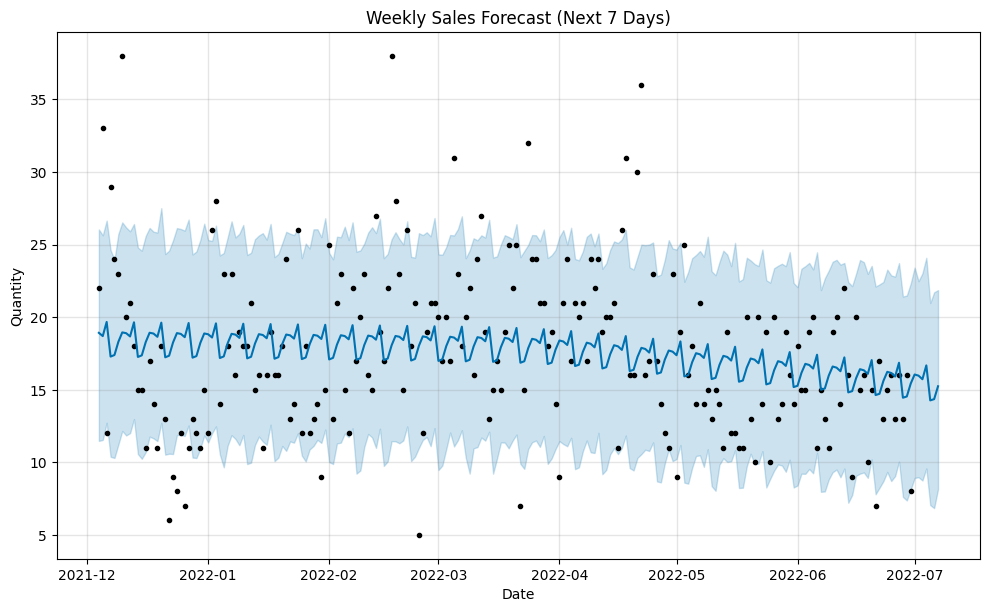

In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Rename columns for Prophet to meet its requirements
data_prophet = product_clicks_impression_update.rename(columns={'Day Index': 'ds', 'Quantity': 'y'})

# Initialize Prophet model with weekly seasonality
prophet_model = Prophet(weekly_seasonality=True)
prophet_model.fit(data_prophet[['ds', 'y']])

# Make a forecast for the next 7 days (weekly)
future_weeks = prophet_model.make_future_dataframe(periods=7, freq='D')  # Forecasting 7 days into the future
forecast_weekly = prophet_model.predict(future_weeks)

# Calculate evaluation metrics for the last 7 days
y_true = data_prophet['y'][-7:].values  # Use last 7 actual days for evaluation
y_pred_prophet_weekly = forecast_weekly['yhat'][-7:].values  # Forecasted values for the next 7 days

# Calculate evaluation metrics
mae_prophet_weekly = mean_absolute_error(y_true, y_pred_prophet_weekly)
mse_prophet_weekly = mean_squared_error(y_true, y_pred_prophet_weekly)
rmse_prophet_weekly = np.sqrt(mse_prophet_weekly)

print(f"Prophet Weekly MAE: {mae_prophet_weekly}")
print(f"Prophet Weekly MSE: {mse_prophet_weekly}")
print(f"Prophet Weekly RMSE: {rmse_prophet_weekly}")

# Plot the forecast for visual interpretation
fig = prophet_model.plot(forecast_weekly)
plt.title("Weekly Sales Forecast (Next 7 Days)")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.show()



Validation Data:
MAE: 75.0000, RMSE: 75.0000, MAPE: 14.0713%, R-square: nan, Adjusted R-square: nan
Test Data:
MAE: 84.6000, RMSE: 105.4808, MAPE: 17.4392%, R-square: -1.3702, Adjusted R-square: 10.4809


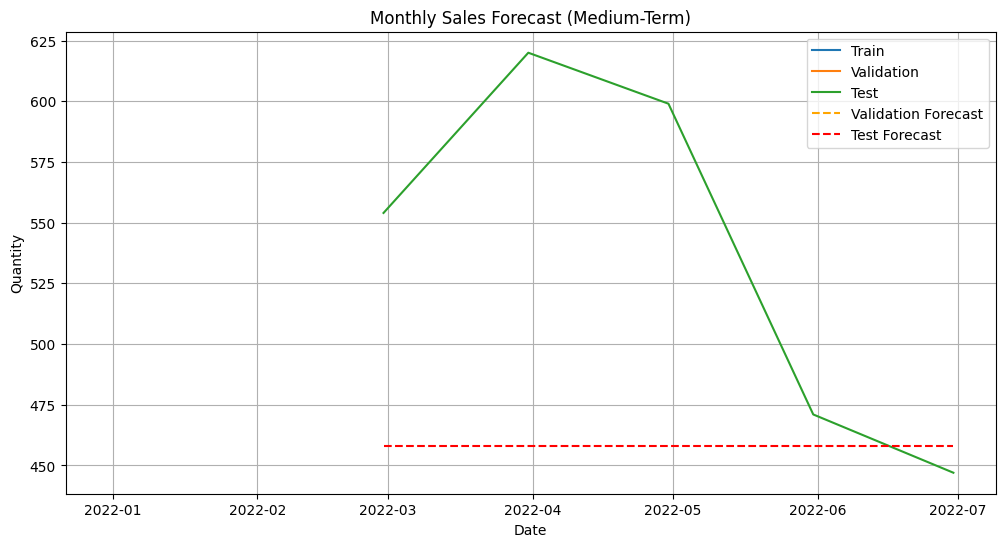

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def SARIMA_Model_Monthly(Dataframe, p, d, q, ratioTest, ratioValidate, attributeQ, SOp, SOd, SOq, SOseason):
    # Resample data to monthly frequency
    monthly_data = Dataframe.set_index('Day Index').resample('M').sum()

    # Split data into training, validation, and test sets
    train_size = int(len(monthly_data) * (1 - ratioTest - ratioValidate))
    validate_size = int(len(monthly_data) * ratioValidate)

    train = monthly_data[attributeQ][:train_size]
    validate = monthly_data[attributeQ][train_size:train_size + validate_size]
    test = monthly_data[attributeQ][train_size + validate_size:]

    # Fit SARIMA model
    model = SARIMAX(train, order=(p, d, q), seasonal_order=(SOp, SOd, SOq, SOseason))
    model_fit = model.fit(disp=False)

    # Forecast for validation period
    validate_forecast = model_fit.get_forecast(steps=len(validate)).predicted_mean

    # Forecast for test period
    test_forecast = model_fit.get_forecast(steps=len(test)).predicted_mean

    # Calculate validation metrics
    valid_mae = mean_absolute_error(validate, validate_forecast)
    valid_rmse = np.sqrt(mean_squared_error(validate, validate_forecast))
    valid_mape = np.mean(np.abs((validate - validate_forecast) / validate))

    valid_r_2 = r2_score(validate, validate_forecast)
    valid_adjusted_r_2 = 1 - (1 - valid_r_2) * (len(validate) - 1) / (len(validate) - len(validate_forecast) - 1)

    # Calculate test metrics
    test_mae = mean_absolute_error(test, test_forecast)
    test_rmse = np.sqrt(mean_squared_error(test, test_forecast))
    test_mape = np.mean(np.abs((test - test_forecast) / test))

    test_r_2 = r2_score(test, test_forecast)
    test_adjusted_r_2 = 1 - (1 - test_r_2) * (len(test) - 1) / (len(test) - len(test_forecast) - 1)

    # Print validation and test results
    print('Validation Data:')
    print(f'MAE: {valid_mae:.4f}, RMSE: {valid_rmse:.4f}, MAPE: {valid_mape * 100:.4f}%, '
          f'R-square: {valid_r_2:.4f}, Adjusted R-square: {valid_adjusted_r_2:.4f}')

    print('Test Data:')
    print(f'MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}, MAPE: {test_mape * 100:.4f}%, '
          f'R-square: {test_r_2:.4f}, Adjusted R-square: {test_adjusted_r_2:.4f}')

    # Plot actuals vs. forecast for validation and test sets
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Train')
    plt.plot(validate.index, validate, label='Validation')
    plt.plot(test.index, test, label='Test')
    plt.plot(validate.index, validate_forecast, label='Validation Forecast', linestyle='--', color='orange')
    plt.plot(test.index, test_forecast, label='Test Forecast', linestyle='--', color='red')
    plt.xlabel('Date')
    plt.ylabel(attributeQ)
    plt.title("Monthly Sales Forecast (Medium-Term)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Usage example
# Ensure `product_clicks_impression_update` is a DataFrame and `'Quantity'` is the column being forecasted
SARIMA_Model_Monthly(product_clicks_impression_update, p=1, d=1, q=1, ratioTest=0.60, ratioValidate=0.20,
                     attributeQ='Quantity', SOp=1, SOd=1, SOq=1, SOseason=12)



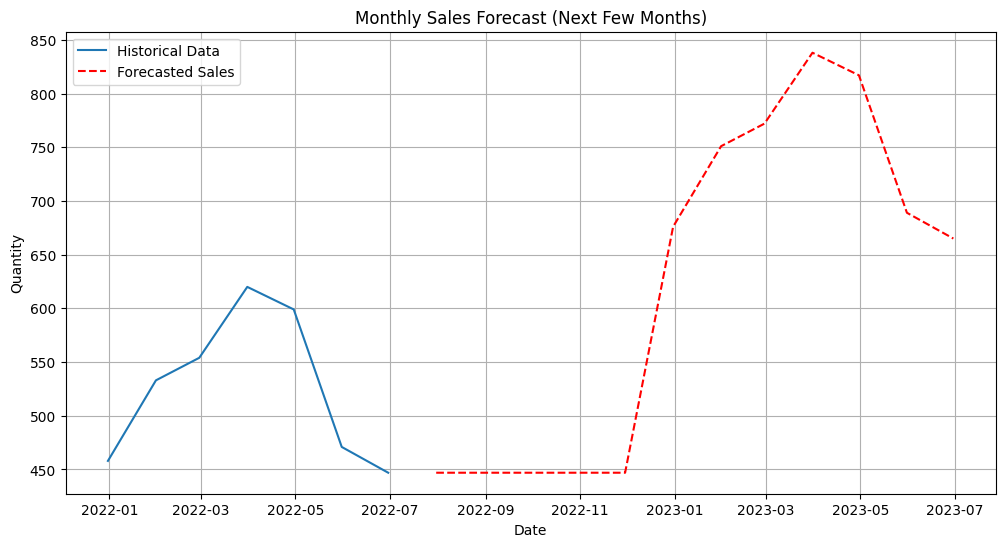

Forecasted Sales for Next Months:
Month: 2022-07, Predicted Sales: 447.00
Month: 2022-08, Predicted Sales: 447.00
Month: 2022-09, Predicted Sales: 447.00
Month: 2022-10, Predicted Sales: 447.00
Month: 2022-11, Predicted Sales: 447.00
Month: 2022-12, Predicted Sales: 676.00
Month: 2023-01, Predicted Sales: 751.00
Month: 2023-02, Predicted Sales: 772.00
Month: 2023-03, Predicted Sales: 838.00
Month: 2023-04, Predicted Sales: 817.00
Month: 2023-05, Predicted Sales: 689.00
Month: 2023-06, Predicted Sales: 665.00


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

def SARIMA_Monthly_Forecasting(Dataframe, p, d, q, attributeQ, SOp, SOd, SOq, SOseason, forecast_periods):
    # Resample data to monthly frequency
    monthly_data = Dataframe.set_index('Day Index').resample('M').sum()

    # Train the SARIMA model
    train = monthly_data[attributeQ]

    # Fit the SARIMA model
    model = SARIMAX(train, order=(p, d, q), seasonal_order=(SOp, SOd, SOq, SOseason))
    model_fit = model.fit(disp=False)

    # Forecast for the next `forecast_periods` months
    forecast = model_fit.get_forecast(steps=forecast_periods)
    forecast_values = forecast.predicted_mean

    # Create future dates for plotting
    future_dates = pd.date_range(start=monthly_data.index[-1] + pd.Timedelta(days=1), periods=forecast_periods, freq='M')

    # Plot the forecasted values
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_data.index, monthly_data[attributeQ], label='Historical Data')
    plt.plot(future_dates, forecast_values, label='Forecasted Sales', linestyle='--', color='red')
    plt.xlabel('Date')
    plt.ylabel(attributeQ)
    plt.title("Monthly Sales Forecast (Next Few Months)")
    plt.legend()
    plt.grid(True)
    plt.show()

    return forecast_values, future_dates

# Usage example
# Ensure `product_clicks_impression_update` is a DataFrame and `'Quantity'` is the column being forecasted
forecast_values, future_dates = SARIMA_Monthly_Forecasting(product_clicks_impression_update, p=1, d=1, q=1,
                                                           attributeQ='Quantity', SOp=1, SOd=1, SOq=1,
                                                           SOseason=12, forecast_periods=12)

# Output the forecasted values
print("Forecasted Sales for Next Months:")
for date, value in zip(future_dates, forecast_values):
    print(f"Month: {date.strftime('%Y-%m')}, Predicted Sales: {value:.2f}")


In [ ]:
# Ensure all features are numeric or properly encoded
# Convert categorical columns (if any) into numeric or categorical dtype for XGBoost compatibility
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# Re-splitting the data after fixing the issue
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the XGBoost model
xgb_model =XGBRegressor(


    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    enable_categorical=True
)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

rmse, mae, y_pred[:5]


(0.6218223940355113,
 0.17369188581194198,
 array([13.000235,  6.859767, 19.99993 , 14.000189, 18.99996 ],
       dtype=float32))